In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
import numpy as np
import os
import pathlib
import sys

In [2]:
code_paths = {}
code_paths["repo_name"] = "p5-stress-classifier"

code_paths["repo_path"] = os.getcwd()
base_dir = os.path.basename(code_paths["repo_path"])
while base_dir != code_paths["repo_name"]:
    code_paths["repo_path"] = os.path.dirname(os.path.abspath(code_paths["repo_path"]))
    base_dir = os.path.basename(code_paths["repo_path"])

package_dir = pathlib.Path(code_paths["repo_path"], "src")
sys.path.append(str(package_dir))
from stresspred import (
    peak_time_to_rri,
    P5_StressDataLoader,
    timestamp_to_samp,
    resample_nonuniform,
    code_paths,
    timestamps_to_audacity_txt,
    find_files_with_string,
    get_camel_case
)

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
for path in code_paths["neurokit2_paths"]:
    sys.path.append(str(path))

In [4]:
from neurokit2 import signal_interpolate, find_outliers
import neurokit2 as nk

In [5]:
#find_files_with_string("to_label", file_dir=code_paths["repo_path"])

In [6]:
anno_dir = "v1"
anno_parent_path = pathlib.Path(r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task2\Task2 Complete")
anno_path = os.path.join(anno_parent_path, anno_dir)

In [7]:
txt_file_paths = [os.path.join(anno_path, f) for f in os.listdir(anno_path) if ".txt" in f]

In [8]:
txt_file_paths

['Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task2\\Task2 Complete\\v1\\P5_Stress-P01-TiPpg-Ann-Manual-LT_v1.txt',
 'Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task2\\Task2 Complete\\v1\\P5_Stress-P01-TiPpg-Ann-Manual-LT_v1_check.txt',
 'Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task2\\Task2 Complete\\v1\\P5_Stress-P01-ZephyrEcg-Ann-Manual-LT_v1.txt']

In [9]:
wav_file_paths = [os.path.join(anno_parent_path, f) for f in os.listdir(anno_parent_path) if ".wav" in f]

In [10]:
list_df = []
for p in txt_file_paths:
    #a = np.genfromtxt(p,delimiter='\t',dtype=str)
    df = pd.read_table(p, header=None)
    if "ZephyrEcg" in p:
        df["signal"] = "ZephyrEcg"
    else:
        df["signal"] = "TiPpg"
    list_df.append(df)

In [11]:
both_df = pd.concat(list_df, ignore_index=True)

In [12]:
test_df = both_df[both_df.iloc[:,3]=="ZephyrEcg"].iloc[:,0:3]
test_df

0            1         2
2129     0.415996     0.415996    R_Peak
2130     1.035990     1.035990    R_Peak
2131     1.667985     1.667985    R_Peak
2132     2.327978     2.327978    R_Peak
2133     3.003972     3.003972    R_Peak
...           ...          ...       ...
8144   768.496544   948.496544  to_label
8145  1144.838267  1324.838267  to_label
8146  1449.507073  1629.507073  to_label
8147  1849.373127  2029.373127  to_label
8148  2145.235283  2325.235283  to_label

[6020 rows x 3 columns]

In [13]:
task_df = both_df[both_df.iloc[:,2]=="to_label"].iloc[:,0:3].drop_duplicates()

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\pandas\core\frame.py:6248: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  diff = Index(subset).difference(self.columns)


In [14]:
anno_info_path = pathlib.Path(
    "Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon",
    "annotation_info.csv",
)

all_results = []
all_results_dict = {}
df = pd.read_csv(anno_info_path)
for index, row in df.iterrows():
    if row["best_version"] == 1:
        p = pathlib.Path(row["parent_path"], row["file_name"])
        
        if p.is_file():
            anno_df = pd.read_table(p, header=None)
            if row["sig_name"] == "zephyr_ecg":
                for label in np.unique(anno_df.iloc[:, 2].values.astype(str)):
                    if "R_Peak" in label:
                        peak_label = label
            else:
                peak_label = "SP"
            peak_time = np.unique(
                np.sort(anno_df[anno_df.iloc[:, 2] == peak_label].iloc[:, 0].values)
            ).astype(float)
            results = dict(row)
            results["peak_time"] = peak_time
            results["to_label_start"] = np.unique(
                np.sort(anno_df[anno_df.iloc[:, 2] == "to_label"].iloc[:, 0].values)
            ).astype(float)
            results["to_label_stop"] = np.unique(
                np.sort(anno_df[anno_df.iloc[:, 2] == "to_label"].iloc[:, 1].values)
            ).astype(float)
            all_results.append(results)
            if row["sub_label"] not in all_results_dict:
                all_results_dict[row["sub_label"]] = {}
            all_results_dict[row["sub_label"]][row["sig_name"]] = results
        else:
            print(p)
            print(p.is_file())

In [15]:
all_results_dict

{'P06': {'zephyr_ecg': {'parent_path': 'Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task1\\Task1 Complete\\v3',
   'file_name': 'P5_Stress-P06-ZephyrEcg-Ann-Manual-LT-Task1_v3.txt',
   'sub_label': 'P06',
   'sig_name': 'zephyr_ecg',
   'checked_by_db': 0,
   'best_version': 1,
   'to_check': nan,
   'entire_file_annotated': 1,
   'peak_time': array([2.89669000e-01, 1.18000000e+00, 2.12762500e+00, ...,
          4.67221650e+03, 4.67321900e+03, 4.67421738e+03]),
   'to_label_start': array([ 180.28902 ,  728.03634 , 1277.518587, 1568.5206  , 2014.254475,
          2303.009507]),
   'to_label_stop': array([ 360.28902 ,  908.03634 , 1457.518587, 1748.5206  , 2194.254475,
          2483.009507])},
  'ti_ppg': {'parent_path': 'Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task1\\Task1 Complete\\v4',
   'file_name': 'P5_Stress-P06-TiPpg-Ann-Manual-LT_v4.txt',
 

In [16]:
labels = anno_df.iloc[:, 2].values.astype(str)
a = anno_df.iloc[[label.lower() in ["good","bad","unsure"] for label in labels],0:2].values.flatten()
unique, counts = np.unique(a, return_counts=True)

In [17]:
anno_df.iloc[[label.lower() in ["good","bad","unsure"] for label in labels],:]

0            1       2
2024   427.301432   442.624180    Good
2025   442.624180   443.972527  Unsure
2026   443.972527   455.094658    Good
2027   455.094658   455.727344  Unsure
2028   455.727344   462.721460    Good
...           ...          ...     ...
2114  2291.325006  2295.148779    Good
2115  2295.148779  2297.292305  Unsure
2116  2297.292305  2317.939295    Good
2117  2317.939295  2319.280727  Unsure
2118  2319.280727  2325.234196    Good

[95 rows x 3 columns]

In [18]:
a

array([ 427.301432,  442.62418 ,  442.62418 ,  443.972527,  443.972527,
        455.094658,  455.094658,  455.727344,  455.727344,  462.72146 ,
        462.72146 ,  464.18044 ,  464.18044 ,  483.361536,  483.361536,
        484.028794,  484.028794,  551.80223 ,  551.80223 ,  552.462574,
        552.462574,  574.65152 ,  574.65152 ,  575.353351,  575.353351,
        590.568925,  590.568925,  592.864571,  592.864571,  596.010714,
        596.010714,  600.353081,  600.353081,  602.752447,  602.752447,
        607.302253,  768.496544,  791.195994,  791.195994,  791.966972,
        791.966972,  828.991188,  828.991188,  830.232359,  830.232359,
        839.439146,  839.439146,  840.638829,  840.638829,  852.614913,
        852.614913,  853.161167,  853.161167,  861.057638,  861.057638,
        861.572775,  861.572775,  876.612027,  876.612027,  877.261999,
        877.261999,  884.031391,  884.031391,  884.619131,  884.619131,
        925.9546  ,  925.9546  ,  926.500853,  926.500853,  937.

In [19]:
a_duration = np.diff(a)
a_labels = anno_df.iloc[[label.lower() in sel_labels for label in labels],2].values

NameError: name 'sel_labels' is not defined

In [ ]:
for label in np.unique(a_labels):
    print(label)
    print((np.sum(a_duration[a_labels==label])/np.sum(a_duration))*100)

In [ ]:
list_for_plot = []
list_sel_labels = [["to_label"], ["good","bad","unsure"]]
labels = anno_df.iloc[:, 2].values.astype(str)
for sel_labels in list_sel_labels:
    a = anno_df.iloc[[label.lower() in sel_labels for label in labels],0:2].values
    sec_vec = np.arange(0, np.ceil(np.max(anno_df.iloc[:,1].values)))
    bin_vec = np.zeros_like(sec_vec)
    for i in range(a.shape[0]):
        bin_vec[(sec_vec >= a[i,0]) & (sec_vec <= a[i,1])] = 1
    list_for_plot.append([sec_vec, bin_vec])

In [ ]:
bin_vec

In [ ]:
plt.plot(list_for_plot[0][1] - list_for_plot[1][1])

In [ ]:
# can have various levels of precision
# but with second-level precision, can be a boolean area with the timestamps marked as true or false if within the start and stop
# then compare to to_label

In [ ]:
a = anno_df.iloc[[label.lower() in ["good","bad","unsure"] for label in labels],0:2].values
a[[t not in a[:,1] for t in a[:,0]],:]

In [ ]:
a[[t not in a[:,0] for t in a[:,1]],:]

In [ ]:
unique[counts == 1]

In [ ]:
anno_df[anno_df.iloc[:, 2] == "to_label"].iloc[:, 0:2].values

In [20]:
np.unique(anno_df.iloc[:, 2].values.astype(str))

array(['Bad', 'DP', 'Good', 'SP', 'Unsure', 'nan', 'to_label'],
      dtype='<U8')

In [21]:
[label.lower() in ["good","bad","unsure"] for label in anno_df.iloc[:, 2].values.astype(str)]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [22]:
all_results_dict

{'P06': {'zephyr_ecg': {'parent_path': 'Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task1\\Task1 Complete\\v3',
   'file_name': 'P5_Stress-P06-ZephyrEcg-Ann-Manual-LT-Task1_v3.txt',
   'sub_label': 'P06',
   'sig_name': 'zephyr_ecg',
   'checked_by_db': 0,
   'best_version': 1,
   'to_check': nan,
   'entire_file_annotated': 1,
   'peak_time': array([2.89669000e-01, 1.18000000e+00, 2.12762500e+00, ...,
          4.67221650e+03, 4.67321900e+03, 4.67421738e+03]),
   'to_label_start': array([ 180.28902 ,  728.03634 , 1277.518587, 1568.5206  , 2014.254475,
          2303.009507]),
   'to_label_stop': array([ 360.28902 ,  908.03634 , 1457.518587, 1748.5206  , 2194.254475,
          2483.009507])},
  'ti_ppg': {'parent_path': 'Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task1\\Task1 Complete\\v4',
   'file_name': 'P5_Stress-P06-TiPpg-Ann-Manual-LT_v4.txt',
 

P06


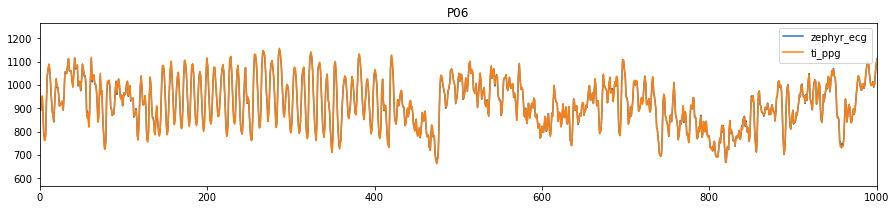

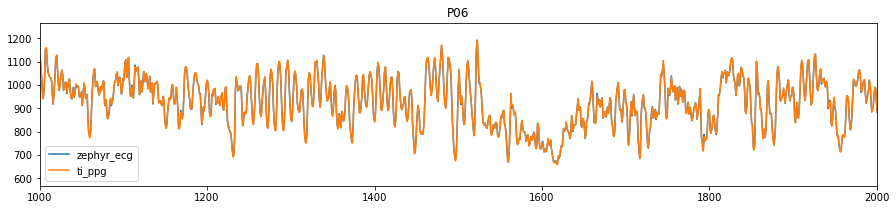

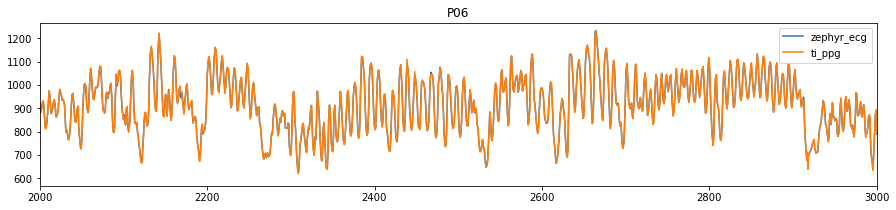

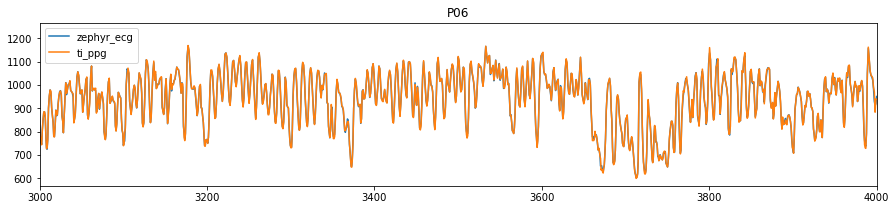

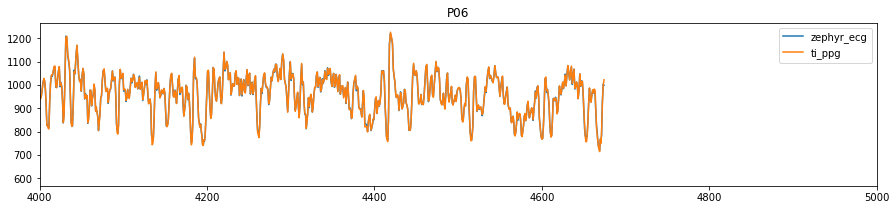

P04_2


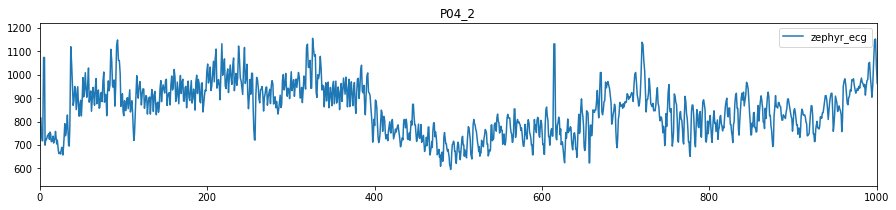

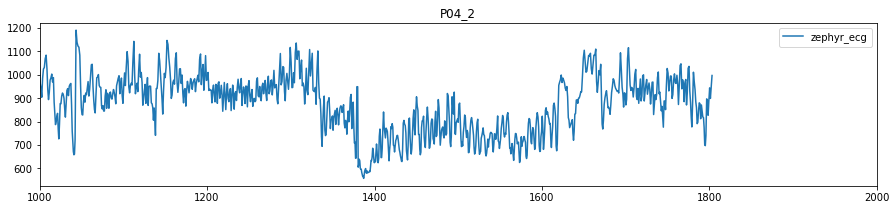

P04_1


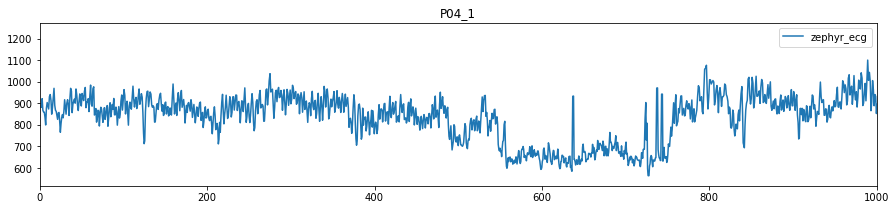

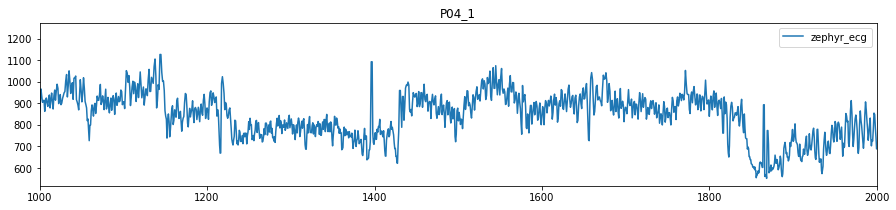

P03


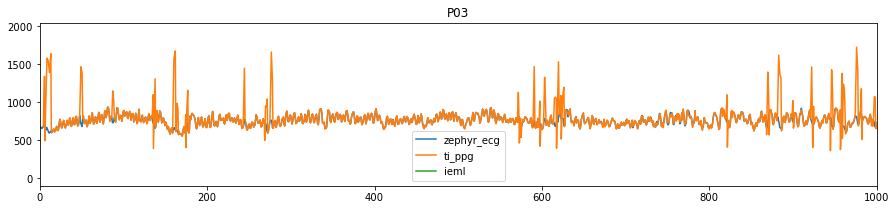

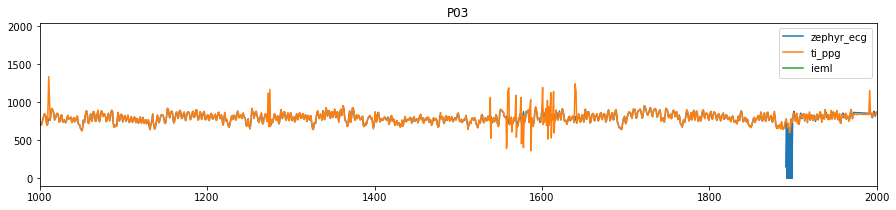

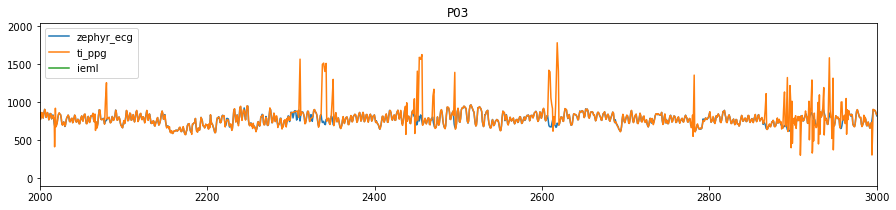

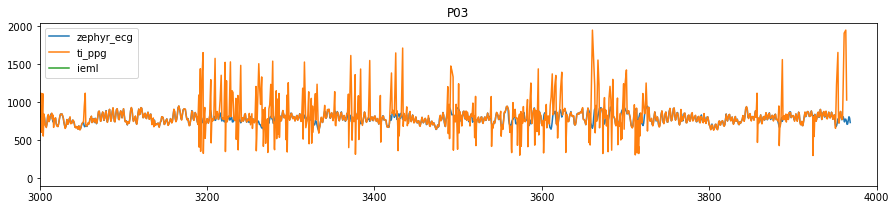

P02_1


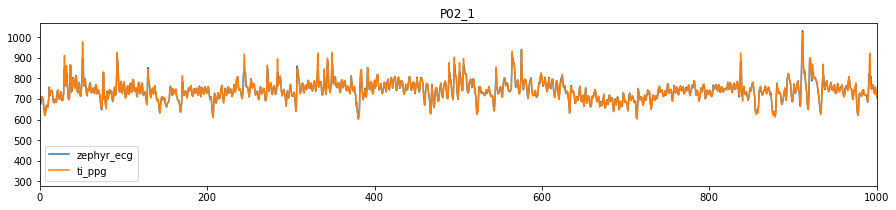

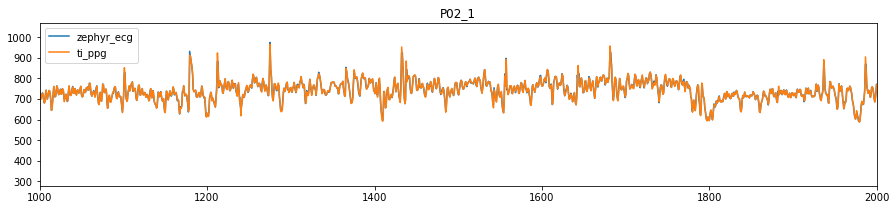

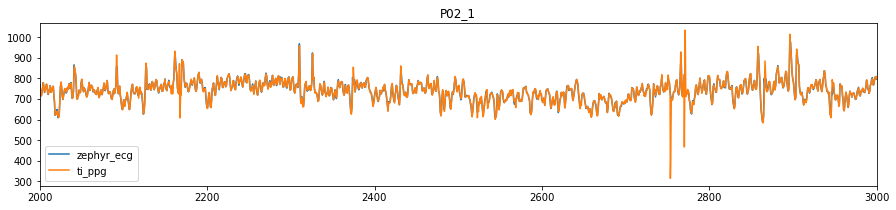

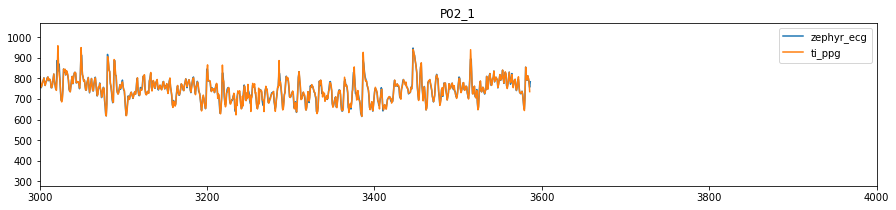

P01


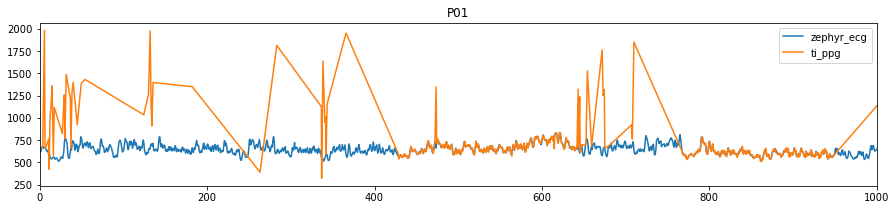

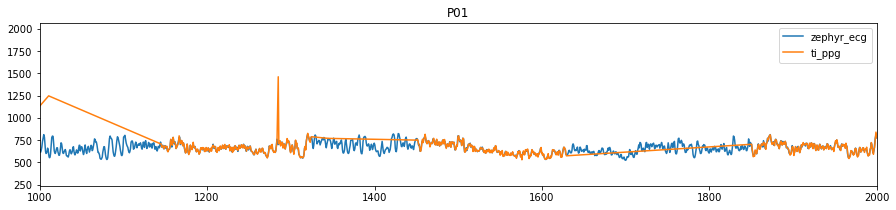

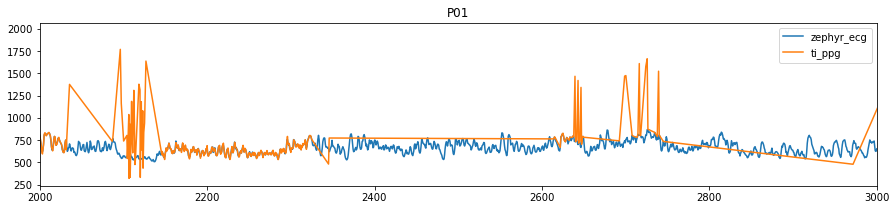

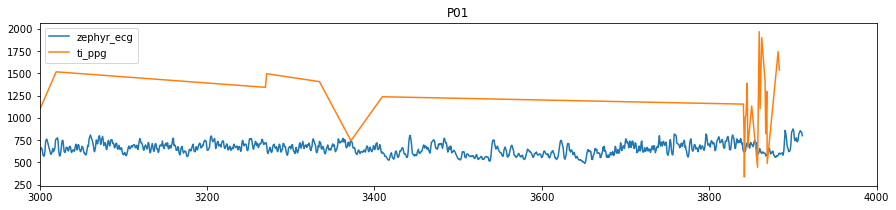

In [23]:
for sub_label in all_results_dict.keys():
    
    legend_list = []
    print(sub_label)
    peak_time = all_results_dict[sub_label]["zephyr_ecg"]["peak_time"]
    for xlim_start in np.arange(0,np.round(np.max(peak_time), -3),1000):
        plt.figure(figsize=(15,3))
        for sig_name in all_results_dict[sub_label].keys():
            peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
            rri, rri_time = peak_time_to_rri(peak_time, min_rri=None, max_rri=2000)
            plt.plot(rri_time, rri)
            legend_list.append(sig_name)
            plt.xlim(xlim_start, xlim_start + 1000)
        plt.legend(legend_list)
        plt.title(sub_label)
        plt.show()

In [24]:
list(all_results_dict[sub_label].keys())[0]

'zephyr_ecg'

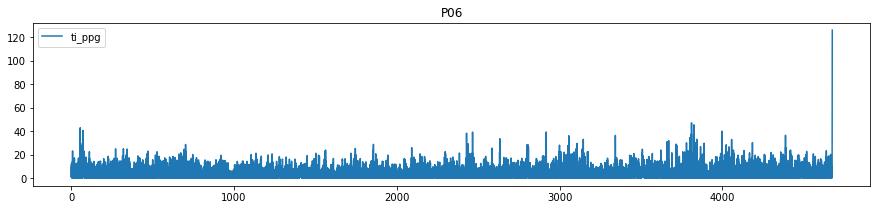

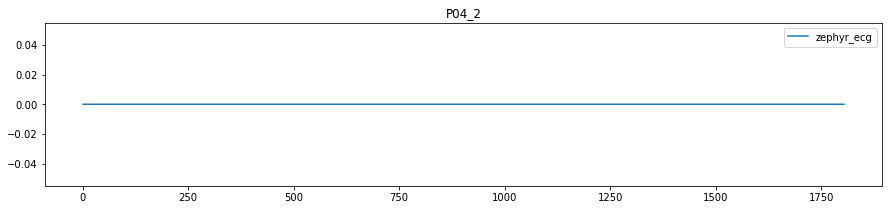

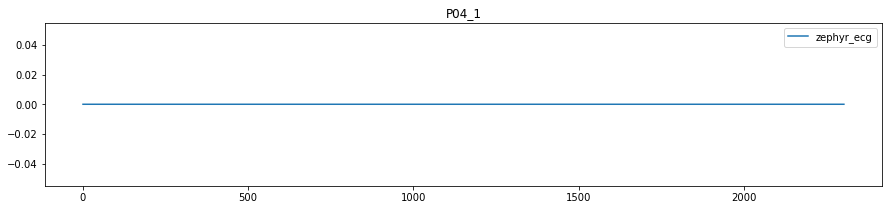

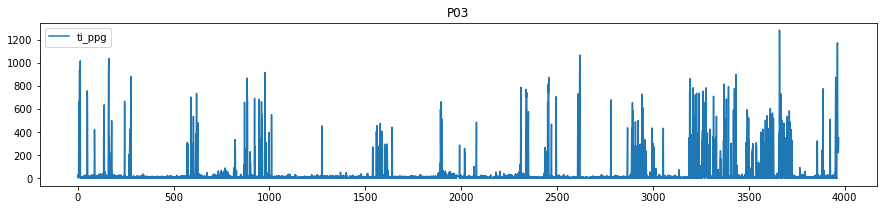

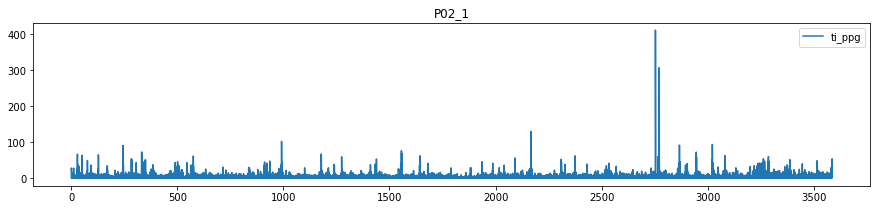

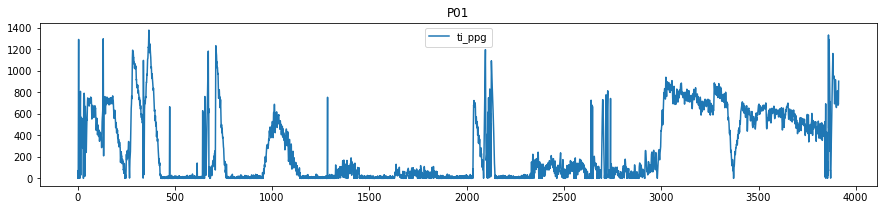

In [25]:
interpolate_method = "linear"
for sub_label in all_results_dict.keys():

    legend_list = []
    peak_time = all_results_dict[sub_label]["zephyr_ecg"]["peak_time"]
    
    list_sig_names = [key_name for key_name in all_results_dict[sub_label].keys() if key_name in ["zephyr_ecg","ti_ppg"]]#list(all_results_dict[sub_label].keys())
    for sig_name in list_sig_names:
        peak_time = all_results_dict[sub_label][sig_name]["peak_time"]

        rri, rri_time = peak_time_to_rri(peak_time, min_rri=None, max_rri=2000)
        
        if sig_name == list_sig_names[0]:
            resamp_rri, resamp_rri_time = resample_nonuniform(
                rri,
                rri_time,
                new_sampling_rate=10,
                interpolate_method=interpolate_method,
                use_matlab=False,
            )
        else:
            resamp_rri = signal_interpolate(
                x_values=rri_time,
                y_values=rri,
                x_new=resamp_rri_time,
                method=interpolate_method,
            )
        all_results_dict[sub_label][sig_name]["resamp_rri"] = resamp_rri
        all_results_dict[sub_label][sig_name]["resamp_rri_time"] = resamp_rri_time
        all_results_dict[sub_label][sig_name]["resamp_rri_diff"] = np.abs(
            resamp_rri - all_results_dict[sub_label][list_sig_names[0]]["resamp_rri"]
        )
    plt.figure(figsize=(15, 3))
    plt.plot(resamp_rri_time, all_results_dict[sub_label][sig_name]["resamp_rri_diff"] )
    plt.legend([sig_name])
    plt.title(sub_label)
    plt.show()

In [105]:
sub_label = "P04_1"
sig_name = "ti_ppg"
y = all_results_dict[sub_label][sig_name]["resamp_rri_diff"]
x = all_results_dict[sub_label][sig_name]["resamp_rri_time"]
out = y[find_outliers(y, side="right", exclude=0.05)]
np.min(out)

KeyError: 'ti_ppg'

In [69]:
p = pathlib.Path(
    all_results_dict[sub_label][sig_name]["parent_path"],
    all_results_dict[sub_label][sig_name]["file_name"],
)
if p.is_file():
    anno_df = pd.read_table(p, header=None)
else:
    print("problem")

In [70]:
all_results_dict.keys()

dict_keys(['P06', 'P04_2', 'P04_1', 'P03', 'P02_1', 'P01'])

In [71]:
np.max(y)

411.14541753013674

In [72]:
out_ind = (y > 50)
out_x = x[out_ind]

In [73]:
len(out_x)

167

In [74]:
min_bpm = 40
min_rri = 60000/40
out[0] - min_rri/1000


24.376373448903678

In [75]:
min_rri/1000

1.5

In [76]:
v = out_ind
#np.array(find_outliers(y, side="right", exclude=0.05))

In [77]:
np.arange(1,16)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [78]:
ind_ar = np.array([1, 19, 21, 22])
all_ind_ar = ind_ar
for ind in np.arange(1,16):
    all_ind_ar = np.concatenate((all_ind_ar, ind_ar - ind))
    all_ind_ar = np.concatenate((all_ind_ar, ind_ar + ind))
    
fin_ind_ar = np.unique(all_ind_ar[(all_ind_ar >= 0) & (all_ind_ar < len(v))])
fin_ind_ar

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [79]:
ind_ar = np.where(out_ind)[0]
all_ind_ar = ind_ar
for ind in np.arange(1,16):
    all_ind_ar = np.concatenate((all_ind_ar, ind_ar - ind))
    all_ind_ar = np.concatenate((all_ind_ar, ind_ar + ind))
    
fin_ind_ar = np.unique(all_ind_ar[(all_ind_ar >= 0) & (all_ind_ar < len(x))])
fin_ind_ar

array([  270,   271,   272, ..., 35857, 35858, 35859], dtype=int64)

In [80]:
v = np.array([i in fin_ind_ar for i in np.arange(0,len(x))])

In [81]:
np.where(v==True)

(array([  270,   271,   272, ..., 35857, 35858, 35859], dtype=int64),)

In [82]:
all_ind_ar

array([  285,   286,   502, ..., 35862, 35863, 35874], dtype=int64)

In [83]:
np.where(v[:-1] != v[1:])[0]

array([  269,   301,   486,   527,  1258,  1292,  2408,  2454,  2815,
        2855,  3294,  3337,  3467,  3507,  5731,  5762,  9888,  9926,
       11757, 11794, 12717, 12753, 14361, 14392, 15538, 15582, 16405,
       16438, 20892, 20924, 21639, 21685, 23068, 23102, 23721, 23754,
       27507, 27549, 27632, 27664, 27673, 27723, 28638, 28675, 29428,
       29475, 30181, 30227, 30777, 30814, 32597, 32628, 32833, 32865,
       33839, 33870, 35829], dtype=int64)

In [84]:
print(v[0])
print(np.where(v[:-1] != v[1:])[0])
all_st_ind = []
all_en_ind = []
all_val = []
all_ch_ind = np.where(v[:-1] != v[1:])[0]
list_a = []
for i in range(len(all_ch_ind)):
    ch_ind = all_ch_ind[i]
    if i == 0:
        st_ind = 0
        en_ind = ch_ind
        val = v[0]
        list_a.append(np.array([st_ind, en_ind, val]))
    else:
        st_ind = en_ind + 1
        en_ind = ch_ind
        val = not val
        list_a.append(np.array([st_ind, en_ind, val]))

st_ind = en_ind + 1
en_ind = len(v) - 1
val = not val
list_a.append(np.array([st_ind, en_ind, val]))

list_t = []
for a in list_a:
    if a[2] == 1:
        list_t.append(np.array([x[a[0]], x[a[1]]]))#, a[2]]))

arr_t = np.array(list_t)

False
[  269   301   486   527  1258  1292  2408  2454  2815  2855  3294  3337
  3467  3507  5731  5762  9888  9926 11757 11794 12717 12753 14361 14392
 15538 15582 16405 16438 20892 20924 21639 21685 23068 23102 23721 23754
 27507 27549 27632 27664 27673 27723 28638 28675 29428 29475 30181 30227
 30777 30814 32597 32628 32833 32865 33839 33870 35829]


In [85]:
np.set_printoptions(suppress=True)

print(arr_t)

[[  28.    31.1]
 [  49.7   53.7]
 [ 126.9  130.2]
 [ 241.9  246.4]
 [ 282.6  286.5]
 [ 330.5  334.7]
 [ 347.8  351.7]
 [ 574.2  577.2]
 [ 989.9  993.6]
 [1176.8 1180.4]
 [1272.8 1276.3]
 [1437.2 1440.2]
 [1554.9 1559.2]
 [1641.6 1644.8]
 [2090.3 2093.4]
 [2165.  2169.5]
 [2307.9 2311.2]
 [2373.2 2376.4]
 [2751.8 2755.9]
 [2764.3 2767.4]
 [2768.4 2773.3]
 [2864.9 2868.5]
 [2943.9 2948.5]
 [3019.2 3023.7]
 [3078.8 3082.4]
 [3260.8 3263.8]
 [3284.4 3287.5]
 [3385.  3388. ]
 [3584.  3586.9]]


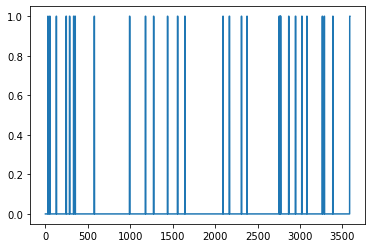

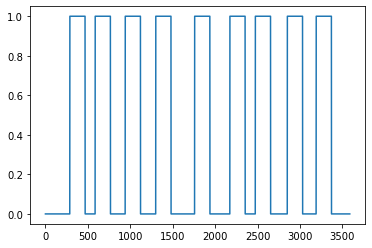

In [86]:
labels = anno_df.iloc[:, 2].values.astype(str)
a_s = [arr_t, anno_df.iloc[[label.lower() in ["good","bad","unsure"] for label in labels],0:2].values]
compare_bin_vec = []
for a in a_s:
    plt.figure()
    t_vec_fs = 10
    t_vec = np.arange(0, np.ceil(np.max(anno_df.iloc[:,1].values))*t_vec_fs)/t_vec_fs
    bin_vec = np.zeros_like(t_vec)
    for i in range(a.shape[0]):
        bin_vec[(t_vec >= a[i,0]) & (t_vec <= a[i,1])] = 1
    compare_bin_vec.append(bin_vec)
    plt.plot(t_vec, bin_vec)
    plt.show()

In [87]:
v = np.array((compare_bin_vec[0]==1) & (compare_bin_vec[1]==1))
x = t_vec

In [88]:
all_st_ind = []
all_en_ind = []
all_val = []
all_ch_ind = np.where(v[:-1] != v[1:])[0]
list_a = []
for i in range(len(all_ch_ind)):
    ch_ind = all_ch_ind[i]
    if i == 0:
        st_ind = 0
        en_ind = ch_ind
        val = v[0]
        list_a.append(np.array([st_ind, en_ind, val]))
    else:
        st_ind = en_ind + 1
        en_ind = ch_ind
        val = not val
        list_a.append(np.array([st_ind, en_ind, val]))

st_ind = en_ind + 1
en_ind = len(v) - 1
val = not val
list_a.append(np.array([st_ind, en_ind, val]))

list_t = []
for a in list_a:
    if a[2] == 1:
        list_t.append(np.array([x[a[0]], x[a[1]]]))#, a[2]]))

arr_t = np.array(list_t)

In [89]:
arr_t
if sub_label=="P06":
    arr_t = arr_t[arr_t < 4672]
    
if len(arr_t.shape) < 2:
    arr_t = np.array(arr_t).reshape(-1,2)

In [90]:
arr_t

array([[ 330.5,  334.7],
       [ 347.8,  351.7],
       [ 989.9,  993.6],
       [1437.2, 1440.2],
       [2307.9, 2311.2],
       [2864.9, 2868.5],
       [2943.9, 2948.5],
       [3019.2, 3023.7],
       [3260.8, 3263.8],
       [3284.4, 3287.5]])

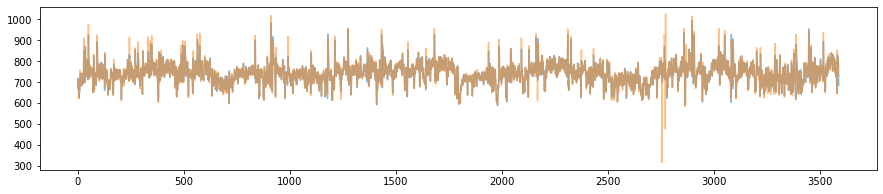

In [91]:
plt.figure(figsize=(15, 3))
for sig_name in ["zephyr_ecg", "ti_ppg"]:
    
    y = all_results_dict[sub_label][sig_name]["resamp_rri"]
    x = all_results_dict[sub_label][sig_name]["resamp_rri_time"]
    plt.plot(x, y, alpha=0.5)
plt.show()

In [92]:
wav_file_paths[0]

'Z:\\Shared\\Documents\\RD\\RD2\\_AudioRD\\datasets\\Biosignals\\CritiasStress\\data_derivatives\\Stage_ltallon\\Task3\\P5_Stress-P03-TiPpg-Sig-Clean.wav'

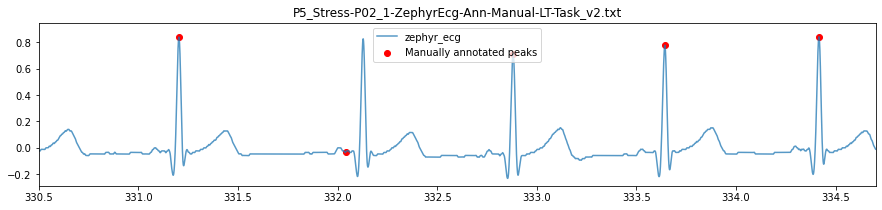

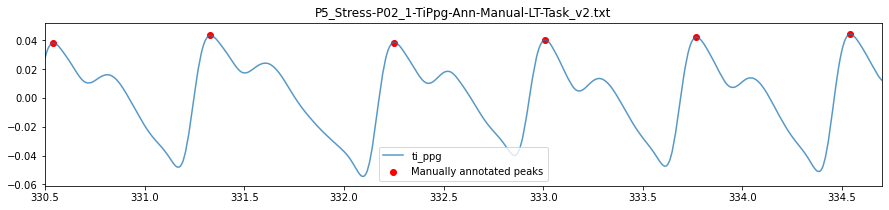

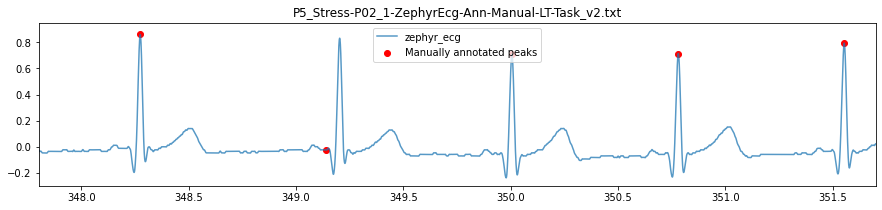

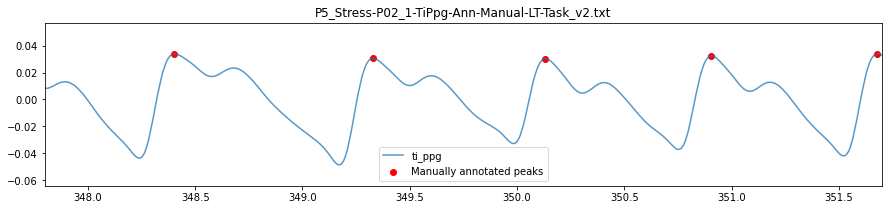

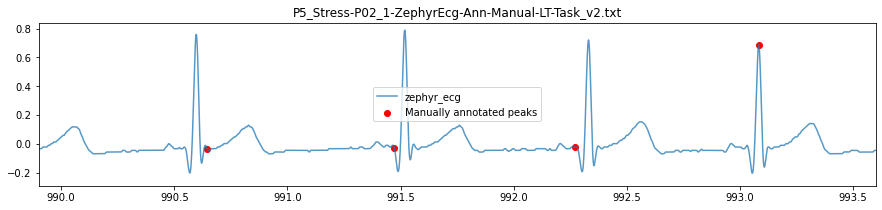

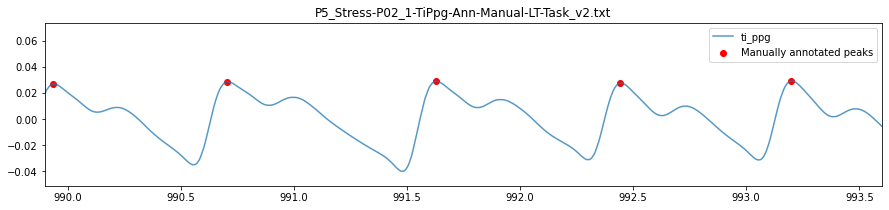

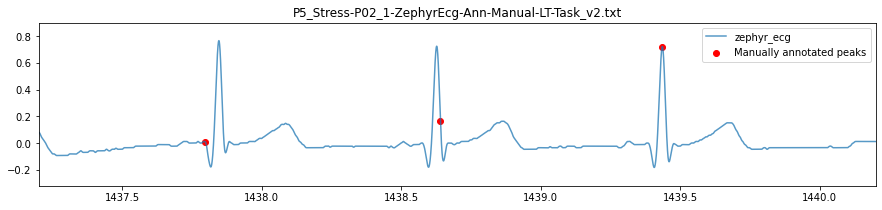

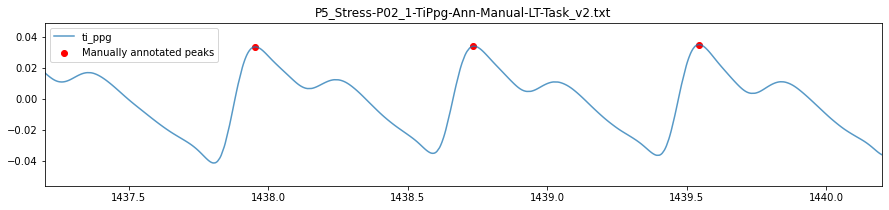

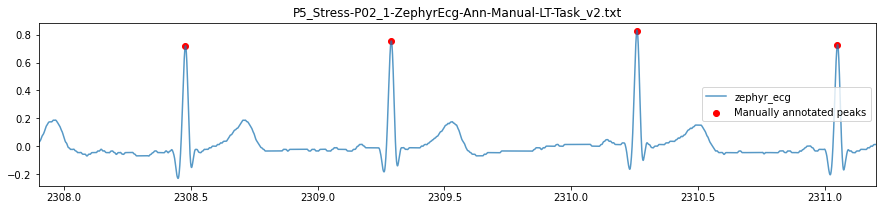

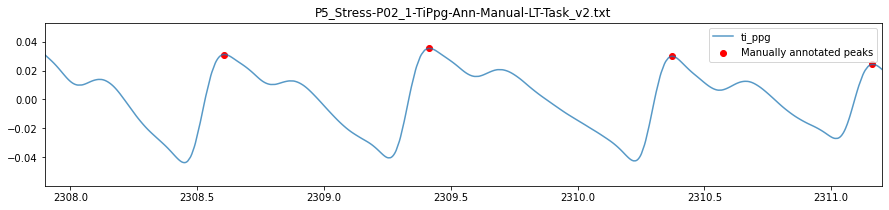

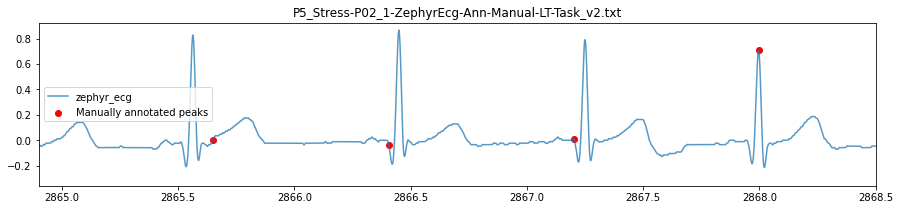

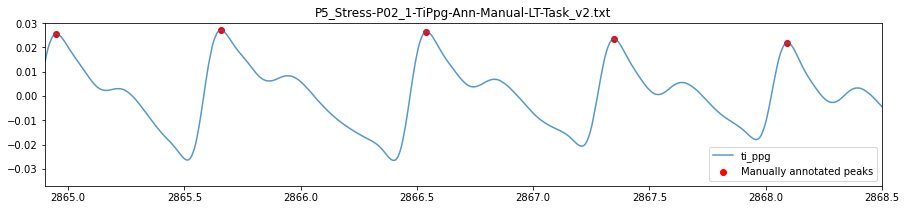

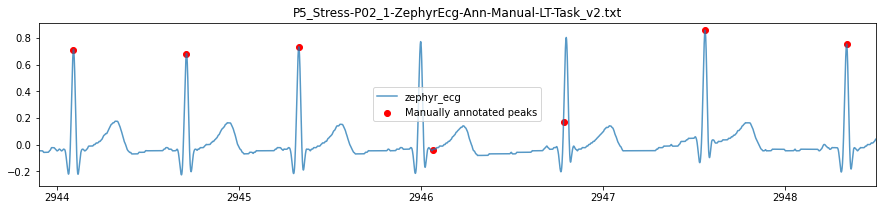

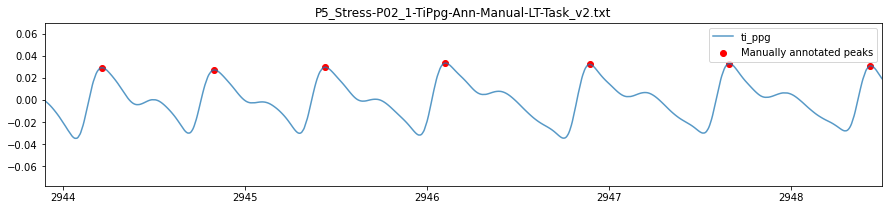

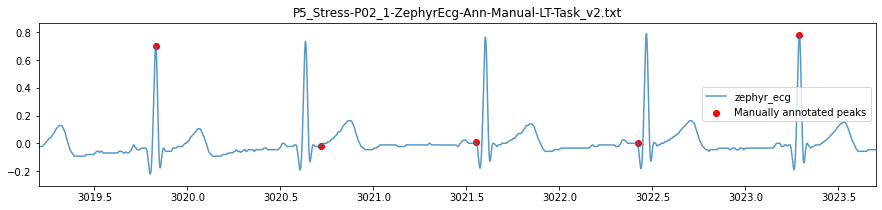

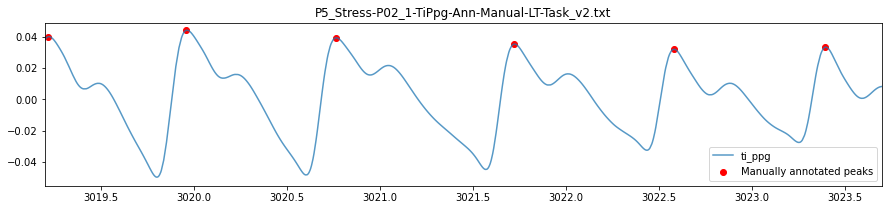

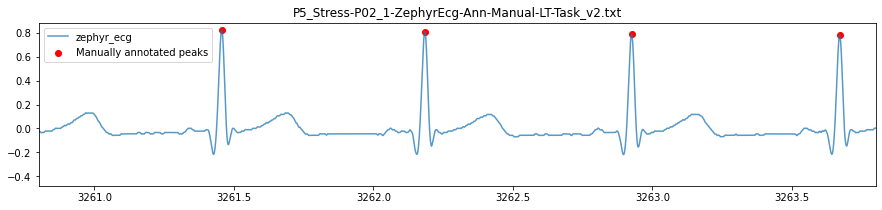

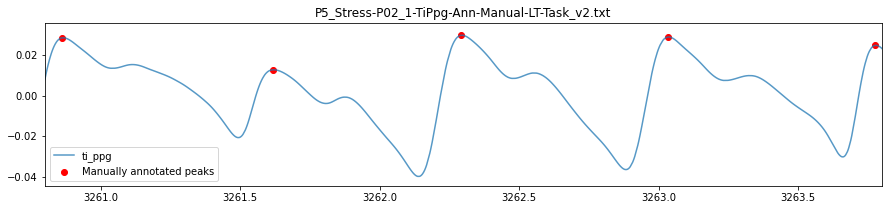

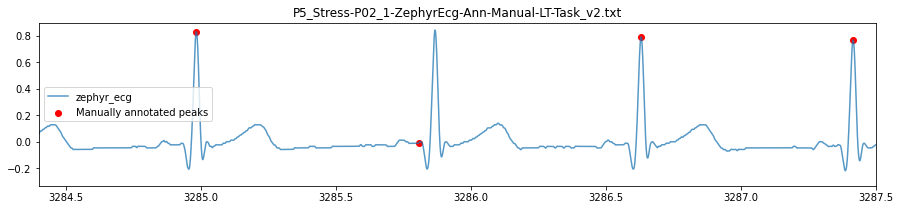

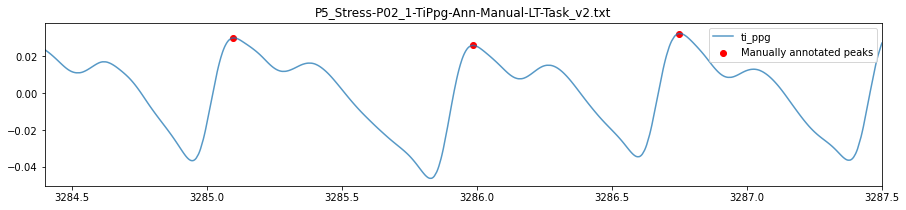

In [93]:
anno_parent_path = pathlib.Path(all_results_dict[sub_label][sig_name]["parent_path"]).parent.parent

for t_pair in arr_t:
    st = t_pair[0]
    en = t_pair[1]
    loader = P5_StressDataLoader(sub_id=sub_label)
    for sig_name in ["zephyr_ecg", "ti_ppg"]:
        wav_file_paths = [
            os.path.join(anno_parent_path, f)
            for f in os.listdir(anno_parent_path)
            if ".wav" in f and get_camel_case(sig_name, first_upper=True) in f
        ]
        if len(wav_file_paths) > 1:
            file_path = wav_file_paths[0]#[1]
        else:
            file_path = wav_file_paths[0]
        sig_info = loader.get_sig(
            sig_name,
            data_format="DB8k",
            file_path=file_path,
            start_time=st - 10,
            end_time=en + 10,
        )
        plt.figure(figsize=(15, 3))
        peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
        peak_time = peak_time[(peak_time >= st) & (peak_time <= en)]
        plt.plot(sig_info["time"], sig_info["sig"], alpha=0.75)
        samp = timestamp_to_samp(
            peak_time,
            sampling_rate=sig_info["sampling_rate"],
            sig_time=sig_info["time"],
        )
        plt.scatter(sig_info["time"][samp], sig_info["sig"][samp], color="red")
        plt.xlim(st, en)
        plt.legend([sig_name, "Manually annotated peaks"])
        plt.title(all_results_dict[sub_label][sig_name]["file_name"])
        plt.show()

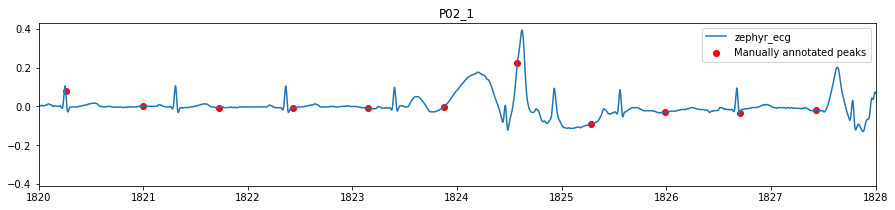

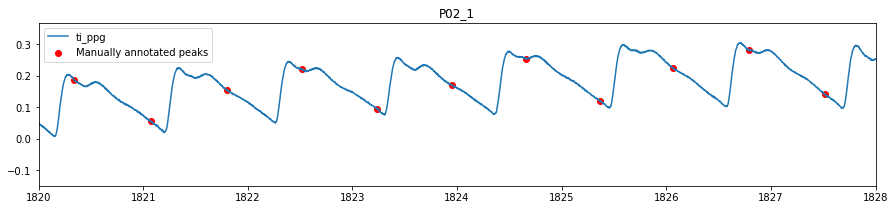

In [94]:
st = 1820
en = 1828
loader = P5_StressDataLoader(sub_id=sub_label)
for sig_name in ["zephyr_ecg", "ti_ppg"]:
    if sig_name == "zephyr_ecg":
        file_path = pathlib.Path(
            r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-ZephyrEcg-Sig-Raw.wav"
        )
    else:
        file_path = pathlib.Path(
            r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-TiPpg-Sig-Raw.wav"
        )
    sig_info = loader.get_sig(sig_name, data_format="DB8k", file_path=file_path, start_time=st - 10, end_time=en + 10)
    plt.figure(figsize=(15, 3))
    peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
    peak_time = peak_time[(peak_time >= st) & (peak_time <= en)]
    plt.plot(sig_info["time"],sig_info["sig"])
    samp = timestamp_to_samp(peak_time, sampling_rate=sig_info["sampling_rate"], sig_time=sig_info["time"])
    plt.scatter(sig_info["time"][samp], sig_info["sig"][samp], color="red")
    plt.xlim(st, en)
    plt.legend([sig_name, "Manually annotated peaks"])
    plt.title(sub_label)
    plt.show()

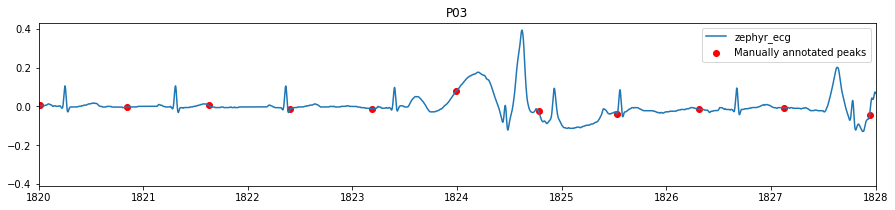

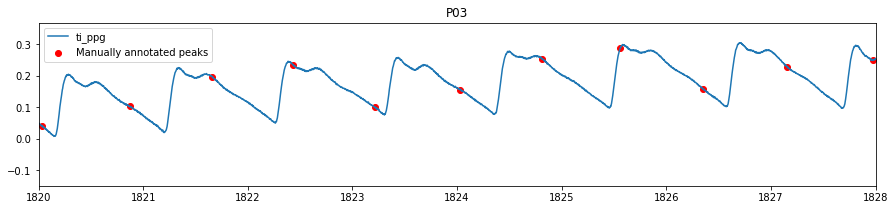

In [252]:
st = 1820
en = 1828
loader = P5_StressDataLoader(sub_id=sub_label)
for sig_name in ["zephyr_ecg", "ti_ppg"]:
    if sig_name == "zephyr_ecg":
        file_path = pathlib.Path(
            r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-ZephyrEcg-Sig-Raw.wav"
        )
    else:
        file_path = pathlib.Path(
            r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-TiPpg-Sig-Raw.wav"
        )
    sig_info = loader.get_sig(sig_name, data_format="DB8k", file_path=file_path, start_time=st - 10, end_time=en + 10)
    plt.figure(figsize=(15, 3))
    peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
    peak_time = peak_time[(peak_time >= st) & (peak_time <= en)]
    plt.plot(sig_info["time"],sig_info["sig"])
    samp = timestamp_to_samp(peak_time, sampling_rate=sig_info["sampling_rate"], sig_time=sig_info["time"])
    plt.scatter(sig_info["time"][samp], sig_info["sig"][samp], color="red")
    plt.xlim(st, en)
    plt.legend([sig_name, "Manually annotated peaks"])
    plt.title(sub_label)
    plt.show()

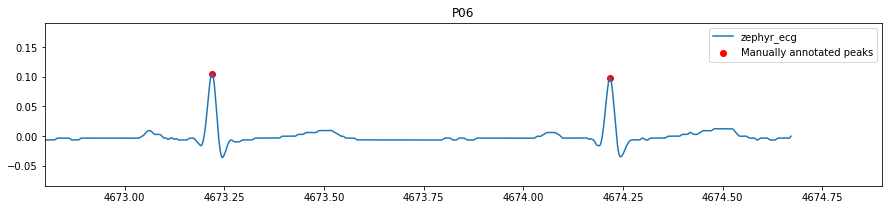

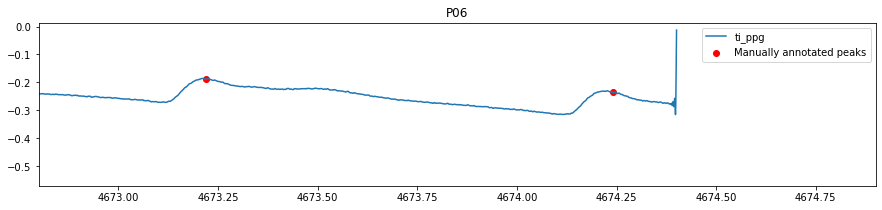

In [301]:
st = 4672.8
en = 4674.9

loader = P5_StressDataLoader(sub_id=sub_label)
for sig_name in ["zephyr_ecg", "ti_ppg"]:
    if sig_name == "zephyr_ecg":
        file_path = pathlib.Path(
            r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-ZephyrEcg-Sig-Raw.wav"
        )
    else:
        file_path = pathlib.Path(
            r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-TiPpg-Sig-Raw.wav"
        )
    sig_info = loader.get_sig(sig_name, data_format="DB8k", file_path=file_path, start_time=st - 10, end_time=en + 10)
    plt.figure(figsize=(15, 3))
    peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
    peak_time = peak_time[(peak_time >= st) & (peak_time <= en)]
    plt.plot(sig_info["time"],sig_info["sig"])
    samp = timestamp_to_samp(peak_time, sampling_rate=sig_info["sampling_rate"], sig_time=sig_info["time"])
    plt.scatter(sig_info["time"][samp], sig_info["sig"][samp], color="red")
    plt.xlim(st, en)
    plt.legend([sig_name, "Manually annotated peaks"])
    plt.title(sub_label)
    plt.show()

C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:314: UserWarning: Warning: the sample index is greater than the last sample index. Changing the sample index to the last sample index.
  warn(
C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:320: UserWarning: Warning: the sample index is less than 0. Changing the sample index to 0.
  warn(


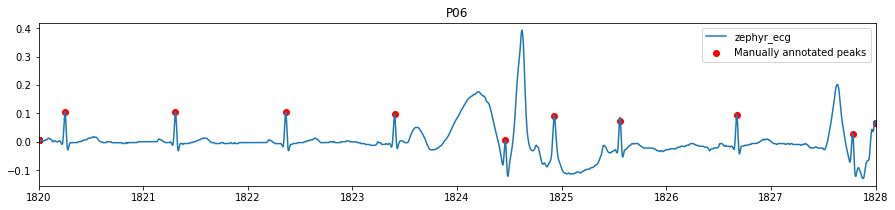

In [302]:
st = 1820
en = 1828
file_path = pathlib.Path(
    r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-ZephyrEcg-Sig-Raw.wav"
)
loader = P5_StressDataLoader(sub_id=sub_label)
sig_name = "zephyr_ecg"
sig_info = loader.get_sig(sig_name, file_path=file_path, start_time=st, end_time=en)
plt.figure(figsize=(15, 3))
peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
plt.plot(sig_info["time"],sig_info["sig"])
samp = timestamp_to_samp(peak_time, sampling_rate=sig_info["sampling_rate"], sig_time=sig_info["time"])
plt.scatter(sig_info["time"][samp], sig_info["sig"][samp], color="red")
plt.xlim(st, en)
plt.legend([sig_name, "Manually annotated peaks"])
plt.title(sub_label)
plt.show()

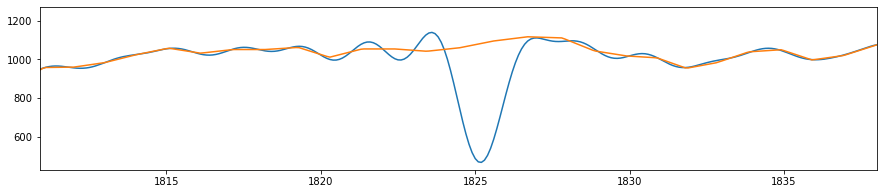

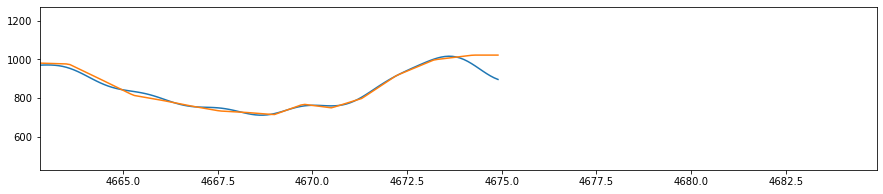

In [303]:
for t_pair in arr_t:
    plt.figure(figsize=(15, 3))
    for sig_name in ["zephyr_ecg", "ti_ppg"]:
        plt.plot(
            all_results_dict[sub_label][sig_name]["resamp_rri_time"],
            all_results_dict[sub_label][sig_name]["resamp_rri"],
        )
    plt.xlim(t_pair[0] - 10, t_pair[1] + 10)
    plt.show()

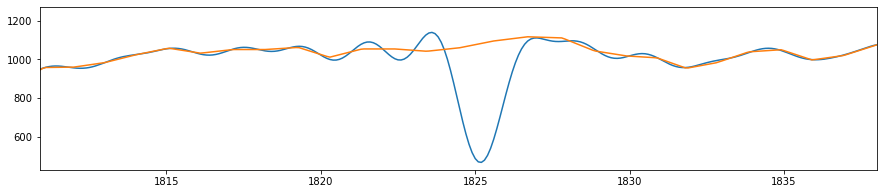

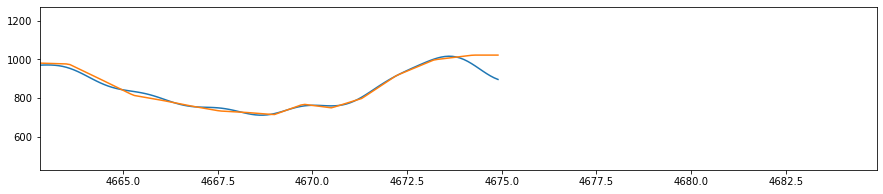

In [304]:
for t_pair in arr_t:
    plt.figure(figsize=(15, 3))
    for sig_name in ["zephyr_ecg", "ti_ppg"]:
        plt.plot(
            all_results_dict[sub_label][sig_name]["resamp_rri_time"],
            all_results_dict[sub_label][sig_name]["resamp_rri"],
        )
    plt.xlim(t_pair[0] - 10, t_pair[1] + 10)
    plt.show()

In [95]:
all_results_dict[sub_label][sig_name]["file_name"]

'P5_Stress-P02_1-TiPpg-Ann-Manual-LT-Task_v2.txt'

In [96]:
len(arr_t)

10

In [97]:
arr_t

array([[ 330.5,  334.7],
       [ 347.8,  351.7],
       [ 989.9,  993.6],
       [1437.2, 1440.2],
       [2307.9, 2311.2],
       [2864.9, 2868.5],
       [2943.9, 2948.5],
       [3019.2, 3023.7],
       [3260.8, 3263.8],
       [3284.4, 3287.5]])

In [98]:
sig_name = "zephyr_ecg"
#sig_name = "ti_ppg"

In [99]:
txt_path = str(
    pathlib.Path(
        all_results_dict[sub_label][sig_name]["parent_path"],
        pathlib.Path(all_results_dict[sub_label][sig_name]["file_name"]).stem
        + "_check.txt",
    )
)

In [104]:
pathlib.Path(txt_path).as_posix()
print(txt_path.replace('\\\\', '\\'))

Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task4\Task4 Complete\v2\P5_Stress-P02_1-ZephyrEcg-Ann-Manual-LT-Task_v2_check.txt


In [64]:
timestamps_to_audacity_txt

<function stresspred.preprocessing.timestamps_to_audacity_txt(timestamp, txt_path='out.txt', label='timestamp', save=True, rewrite=False)>

In [65]:
timestamps_to_audacity_txt(timestamp=arr_t, txt_path=txt_path, label="to_check", rewrite=True)

array([['731.6', '734.9', 'to_check'],
       ['743.4', '746.5', 'to_check'],
       ['747.3', '750.7', 'to_check'],
       ['760.8', '764.0', 'to_check'],
       ['766.1', '769.7', 'to_check'],
       ['773.6', '777.4', 'to_check'],
       ['781.5', '784.5', 'to_check'],
       ['1368.9', '1371.9', 'to_check'],
       ['1881.2', '1884.2', 'to_check'],
       ['1885.9', '1902.2', 'to_check'],
       ['1903.6', '1906.9', 'to_check'],
       ['1915.7', '1918.9', 'to_check'],
       ['1936.9', '1939.9', 'to_check'],
       ['1940.2', '1943.3', 'to_check'],
       ['1989.3', '1993.8', 'to_check'],
       ['2180.1', '2183.1', 'to_check'],
       ['2200.9', '2205.0', 'to_check']], dtype='<U32')

(0.0, 12.0)

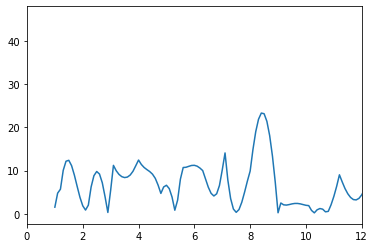

In [95]:
plt.plot(x, y)
plt.xlim([0, 12])

In [93]:
x[np.where(v[:-1] != v[1:])[0]]

array([   7. ,    7.1,    8. , ..., 4673.8, 4674.1, 4674.4])

In [82]:
out[np.concatenate((np.array([True]),np.diff(out)>0.1))]

array([ 916.9,  917. ,  917.1,  917.2,  917.4,  917.5,  917.6,  917.7,
        917.9,  918. ,  918.9,  919. ,  919.1,  919.2,  919.4,  919.5,
        919.6,  919.7,  919.9,  924.7,  924.9,  925. ,  925.1,  925.2,
        925.4,  925.9,  926. ,  926.1,  926.2,  926.4,  926.5,  926.6,
        926.7,  944.8,  944.9,  945. ,  945.1,  945.2,  945.4,  945.5,
        945.6,  945.7,  946.9,  947. ,  947.1,  947.2,  947.4,  947.5,
        947.9,  948. ,  948.1,  948.2,  948.4,  948.5,  948.6,  948.7,
        948.9,  949. ,  949.2,  949.4,  949.5,  949.6,  949.7,  949.9,
        950. ,  950.1,  950.2, 1822.4, 1822.7, 1823.3, 1823.4, 1823.7,
       1824.1, 1824.2, 1824.4, 1824.7, 1824.9, 1825.2, 1825.4, 1825.7,
       1825.9, 1826.2, 1826.4, 2427.2, 2427.3, 2427.8, 2429.9, 2430.3,
       2430.8, 2436.3, 2436.8, 2439.3, 2439.8, 2440.3, 2464.1, 2464.3,
       2464.8, 2466.7, 2466.8, 2467.3, 2467.8, 2475. , 2475.3, 2476.9,
       2477.3, 2477.8, 2495. , 2495.3, 2495.8, 2496.7, 2496.8, 2497.3,
      

In [58]:
out = x[y > 45]
out

array([ 916.9,  917. ,  917.1,  917.2,  917.3,  917.4,  917.5,  917.6,
        917.7,  917.8,  917.9,  918. ,  918.9,  919. ,  919.1,  919.2,
        919.3,  919.4,  919.5,  919.6,  919.7,  919.8,  919.9,  924.7,
        924.8,  924.9,  925. ,  925.1,  925.2,  925.3,  925.4,  925.9,
        926. ,  926.1,  926.2,  926.3,  926.4,  926.5,  926.6,  926.7,
        944.8,  944.9,  945. ,  945.1,  945.2,  945.3,  945.4,  945.5,
        945.6,  945.7,  945.8,  946.9,  947. ,  947.1,  947.2,  947.3,
        947.4,  947.5,  947.9,  948. ,  948.1,  948.2,  948.3,  948.4,
        948.5,  948.6,  948.7,  948.8,  948.9,  949. ,  949.2,  949.3,
        949.4,  949.5,  949.6,  949.7,  949.8,  949.9,  950. ,  950.1,
        950.2, 1822.4, 1822.5, 1822.6, 1822.7, 1823.3, 1823.4, 1823.5,
       1823.6, 1823.7, 1823.8, 1824.1, 1824.2, 1824.3, 1824.4, 1824.5,
       1824.6, 1824.7, 1824.8, 1824.9, 1825. , 1825.1, 1825.2, 1825.3,
       1825.4, 1825.5, 1825.6, 1825.7, 1825.8, 1825.9, 1826. , 1826.1,
      

In [73]:
a = out
reshape_close_arr(a, close=0.1)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [59]:
np.array(True)

array(True)

In [63]:
len(out)

753

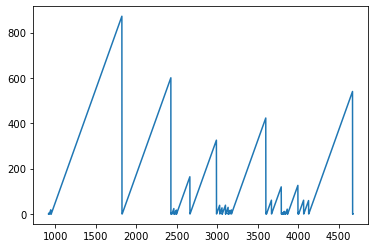

In [60]:
plt.plot(out[1:],np.diff(out))

In [61]:
import neurokit2 as nk
nk.signal_changepoints(np.diff(out), change="meanvar", penalty=None)

C:\Users\dbenesch\eers\git\p5-stress-classifier\lib\NeuroKit\neurokit2\signal\signal_changepoints.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  sig_i = 1.0 / sig
C:\Users\dbenesch\eers\git\p5-stress-classifier\lib\NeuroKit\neurokit2\signal\signal_changepoints.py:92: RuntimeWarning: All-NaN slice encountered
  F[tstar] = np.nanmin(F_cost) + penalty


ValueError: All-NaN slice encountered

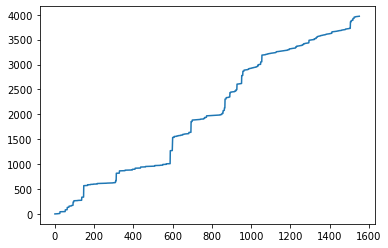

In [50]:
plt.plot(out[np.concatenate((np.array([True]),np.diff(out)>0.1))])

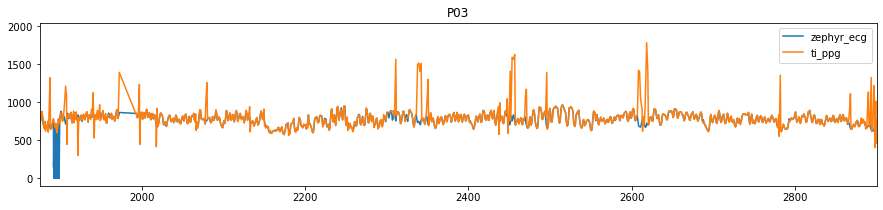

In [12]:
plt.figure(figsize=(15,3))
st = 1875
en = 2900
sub_label = "P03"
for sig_name in all_results_dict[sub_label].keys():
    peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
    rri, rri_time = peak_time_to_rri(peak_time, min_rri=None, max_rri=2000)
    plt.plot(rri_time, rri)
    legend_list.append(sig_name)
    plt.xlim(st, en)
plt.legend(legend_list)
plt.title(sub_label)
plt.show()

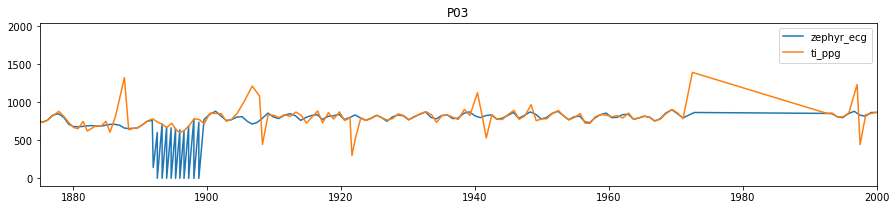

In [16]:
plt.figure(figsize=(15,3))
st = 1875
en = 2000
sub_label = "P03"
for sig_name in all_results_dict[sub_label].keys():
    peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
    rri, rri_time = peak_time_to_rri(peak_time, min_rri=None, max_rri=2000)
    plt.plot(rri_time, rri)
    legend_list.append(sig_name)
    plt.xlim(st, en)
plt.legend(legend_list)
plt.title(sub_label)
plt.show()

C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:208: UserWarning: Warning: the sample index is greater than the last sample index. Changing the sample index to the last sample index.
  warn(
C:\Users\dbenesch\eers\git\p5-stress-classifier\src\stresspred\preprocessing.py:214: UserWarning: Warning: the sample index is less than 0. Changing the sample index to 0.
  warn(


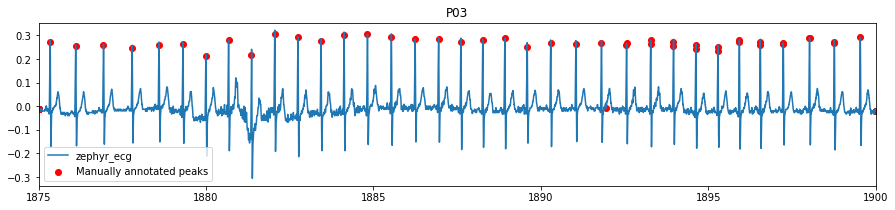

In [17]:
st = 1885
en = 1900
file_path = pathlib.Path(
    r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task3\P5_Stress-P03-ZephyrEcg-Sig-Raw.wav"
)
loader = P5_StressDataLoader(sub_id=sub_label)
sig_name = "zephyr_ecg"
sig_info = loader.get_sig(sig_name, file_path=file_path, start_time=st, end_time=en)
plt.figure(figsize=(15, 3))
peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
plt.plot(sig_info["time"],sig_info["sig"])
samp = timestamp_to_samp(peak_time, sampling_rate=sig_info["sampling_rate"], sig_time=sig_info["time"])
plt.scatter(sig_info["time"][samp], sig_info["sig"][samp], color="red")
plt.xlim(st, en)
plt.legend([sig_name, "Manually annotated peaks"])
plt.title(sub_label)
plt.show()

In [ ]:
plt.figure(figsize=(15,3))
st = 1820
en = 1830
sub_label = "P06"
for sig_name in all_results_dict[sub_label].keys():
    peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
    rri, rri_time = peak_time_to_rri(peak_time, min_rri=None, max_rri=2000)
    plt.plot(rri_time, rri)
    legend_list.append(sig_name)
    plt.xlim(st, en)
plt.legend(legend_list)
plt.title(sub_label)
plt.show()

In [ ]:
file_path = pathlib.Path(
    r"Z:\Shared\Documents\RD\RD2\_AudioRD\datasets\Biosignals\CritiasStress\data_derivatives\Stage_ltallon\Task1\P5_Stress-P06-ZephyrEcg-Sig-Raw.wav"
)

In [ ]:
str(file_path)

In [ ]:
pathlib.Path(file_path).suffix==".wav"

In [ ]:
loader = P5_StressDataLoader(sub_id=sub_label)
sig_name = "zephyr_ecg"
sig_info = loader.get_sig(sig_name, file_path=file_path)
plt.figure(figsize=(15, 3))
peak_time = all_results_dict[sub_label][sig_name]["peak_time"]
plt.plot(sig_info["time"],sig_info["sig"])
samp = timestamp_to_samp(peak_time, sampling_rate=sig_info["sampling_rate"], sig_time=sig_info["time"])
plt.scatter(sig_info["time"][samp], sig_info["sig"][samp], color="red")
plt.xlim(st, en)
plt.legend([sig_name, "Manually annotated peaks"])
plt.title(sub_label)
plt.show()

In [ ]:
both_df[(both_df.iloc[:,2]=="R_Peak" | both_df.iloc[:,2]=="R_Peaks")].iloc[:,0]

In [ ]:
R_Peak = np.unique(np.sort(both_df[both_df.iloc[:,2]=="R_Peak"].iloc[:,0].values)).astype(float)
SP = np.unique(np.sort(both_df[both_df.iloc[:,2]=="SP"].iloc[:,0].values)).astype(float)

In [ ]:
R_Peak

In [ ]:
len(task_df)

In [ ]:
for i in range(len(task_df)):
    plt.figure(figsize=(15,3))
    plt.plot(R_Peak[1:],np.diff(R_Peak),alpha=0.5)
    plt.plot(SP[1:],np.diff(SP),alpha=0.5)
    plt.xlim([task_df.iloc[i,0],task_df.iloc[i,1]])
    plt.show()

In [ ]:
out_list = []
for f in wav_file_paths:
    out_list.append(wavfile.read(f))

In [ ]:
wav_file_paths

In [ ]:
fs = out_list[0][0]
signal = out_list[0][1]
time = np.arange(0, len(signal))/fs

In [ ]:
fs

In [ ]:
st = 1742
en = 1747
plt.figure(figsize=(15,3))
plt.plot(time[st*fs:en*fs], signal[st*fs:en*fs], alpha=0.75)
plt.scatter(SP, signal[np.round(SP*fs).astype(int)],color="red", linewidth=2)
plt.title(os.path.basename(wav_file_paths[0]))
plt.xlabel("Time (seconds)")
plt.xlim([st, en])
plt.ylim([np.min(signal[st*fs:en*fs]), np.max(signal[st*fs:en*fs]) + 100])

In [ ]:
st = 2425
en = 2445
plt.figure(figsize=(15,3))
plt.plot(time[st*fs:en*fs], signal[st*fs:en*fs], alpha=0.75)
plt.scatter(SP, signal[np.round(SP*fs).astype(int)],color="red", linewidth=2)
plt.title(os.path.basename(wav_file_paths[0]))
plt.xlabel("Time (seconds)")
plt.xlim([st, en])
plt.ylim([np.min(signal[st*fs:en*fs]), np.max(signal[st*fs:en*fs]) + 100])

In [ ]:
plt.plot()

In [ ]:
st = 2420
en = 2440
plt.figure(figsize=(15,3))
plt.plot(time[st*fs:en*fs], signal[st*fs:en*fs])
plt.scatter(SP, signal[np.round(SP*fs).astype(int)])
plt.title(os.path.basename(wav_file_paths[0]))
plt.xlabel("Time (seconds)")
plt.xlim([st, en])

In [ ]:
st = 2435
en = 2439
plt.figure(figsize=(15,3))
plt.plot(time[st*fs:en*fs], signal[st*fs:en*fs], alpha=0.75)
plt.scatter(SP, signal[np.round(SP*fs).astype(int)],color="red", linewidth=2)
plt.title(os.path.basename(wav_file_paths[0]))
plt.xlabel("Time (seconds)")
plt.xlim([st, en])
plt.ylim([np.min(signal[st*fs:en*fs]), np.max(signal[st*fs:en*fs])])

In [ ]:
repo_name = "p5-stress-classifier"
submodule_parent_dir = "lib"
submodule_name = "Neurokit"

repo_path = os.getcwd()
base_dir = os.path.basename(repo_path)
while base_dir != repo_name:
    repo_path = os.path.dirname(os.path.abspath(repo_path))
    base_dir = os.path.basename(repo_path)
    
submodule_path = os.path.join(repo_path, submodule_parent_dir, submodule_name)

sys.path.append(submodule_path)

import neurokit2 as nk

In [ ]:
st = st - 10
en = en + 10
processed = nk.ppg_process(signal[st*fs:en*fs], sampling_rate=fs)

In [ ]:
#plt.figure(figsize=(15,3))
fig, ax1 = plt.subplots(figsize=(15,3))

ax2 = ax1.twinx()
processed_no_outliers = processed[0]["PPG_Clean"].values
processed_no_outliers[nk.find_outliers(processed_no_outliers)] = np.mean(processed_no_outliers)
ax1.plot(time[st*fs:en*fs], signal[st*fs:en*fs], 'g', alpha=0.5)
ax2.plot(time[st*fs:en*fs], processed_no_outliers, 'b', alpha=0.5)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Raw PPG', color='g')
ax2.set_ylabel('Clean PPG', color='b')
plt.xlim([st+10, en - 10])

In [ ]:
filtered = nk.signal_filter(signal = signal[st*fs:en*fs], lowcut=0.1, highcut=25)

In [ ]:
#plt.figure(figsize=(15,3))
fig, ax1 = plt.subplots(figsize=(15,3))

ax2 = ax1.twinx()
#filtered = processed[0]["PPG_Clean"].values
#processed_no_outliers[nk.find_outliers(processed_no_outliers)] = np.mean(processed_no_outliers)
ax1.plot(time[st*fs:en*fs], signal[st*fs:en*fs], 'g', alpha=0.5)
ax2.plot(time[st*fs:en*fs], filtered, 'b', alpha=0.5)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Raw PPG', color='g')
ax2.set_ylabel('Filtered PPG', color='b')
plt.xlim([st+10, en - 10])

In [555]:
from stresspred import get_frame_start_stop, get_frame, append_samples_to_wav
def clean_ppg(
    sig,
    sig_time=None,
    wav_path="out.wav",
    sampling_rate=1000,
    frame_len=np.inf,
    method="own_filt",
    show=False
):

    #sig = sig - np.nanmean(sig)
    #sig[np.isnan(sig)] = 0
    #sig = sig / np.max(np.abs(sig))
    in_start_stop, out_start_stop = get_frame_start_stop(sig_time, frame_len=frame_len)
    for frame_n in np.arange(1, len(in_start_stop) + 1):
        
        frame_sig = get_frame(sig, sig_time, in_start_stop, frame_n)
        frame_sig_time = get_frame(sig_time, sig_time, in_start_stop, frame_n)
        frame_sig_time_r = frame_sig_time
        if method=="own_filt":
            frame_sig_r = nk.signal_filter(
                frame_sig,
                sampling_rate=sampling_rate,
                lowcut=0.5,
                highcut=8,
            )
        else:
            frame_sig_r = nk.ppg_clean(frame_sig, sampling_rate=sampling_rate)
        out_frame_sig_r = get_frame(
            frame_sig_r, frame_sig_time_r, out_start_stop, frame_n
        )
        out_frame_sig_time_r = get_frame(
            frame_sig_time_r, frame_sig_time_r, out_start_stop, frame_n
        )
        if show:
            plt.figure(figsize=(15,3))
            plt.plot(frame_sig_time, frame_sig)
            plt.plot(frame_sig_time_r, frame_sig_r)
            plt.plot(out_frame_sig_time_r, out_frame_sig_r)
            plt.xlabel("Time (s)")
            plt.title("Frame " + str(frame_n))
            plt.legend(["Original input signal", "Processed input signal", "Output signal"])
            plt.show()
        if frame_n == 1:
            append_samples_to_wav(
                out_frame_sig_r, wav_path, sampling_rate, rewrite=True
            )
        else:
            append_samples_to_wav(
                out_frame_sig_r, wav_path, sampling_rate, rewrite=False
            )
    if frame_len == np.inf:
        out_frame_sig_r_time = get_frame(
            frame_sig_time_r, frame_sig_time_r, out_start_stop, frame_n
        )
        sig_info = {}
        sig_info["sig"] = out_frame_sig_r
        sig_info["time"] = out_frame_sig_r_time
        sig_info["sampling_rate"] = sampling_rate
        return sig_info

In [558]:
all_results_dict.keys()

dict_keys(['P06', 'P04_2', 'P04_1', 'P03', 'P02_1', 'P01'])

In [568]:
anno_parent_path = anno_info_path.parent


[WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task1'),
 WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task2'),
 WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task3'),
 WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task4'),
 WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task5'),
 WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task6'),
 WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task7')]

In [577]:
anno_parent_paths

[WindowsPath('Z:/Shared/Documents/RD/RD2/_AudioRD/datasets/Biosignals/CritiasStress/data_derivatives/Stage_ltallon/Task2/Task2 Complete')]

In [588]:
sig_name = "ti_ppg"

"""
anno_parent_path = pathlib.Path(
    all_results_dict[sub_label][sig_name]["parent_path"]
).parent.parent
"""

anno_parent_paths = [d for d in anno_info_path.parent.glob("Task*") if d.is_dir()]
anno_parent_path = anno_parent_paths[6]
wav_file_paths = [
    os.path.join(anno_parent_path, f)
    for f in os.listdir(anno_parent_path)
    if ".wav" in f and get_camel_case(sig_name, first_upper=True) in f
]
file_path = wav_file_paths[0]
sub_label = pathlib.Path(file_path).stem.split("-")[1][:3]
loader = P5_StressDataLoader(sub_id=sub_label)
sig_info = loader.get_sig(sig_name, data_format="DB8k", file_path=file_path)

In [589]:
wav_path = str(
    pathlib.Path(
        pathlib.Path(file_path).parent,
        pathlib.Path(file_path).stem.split("-Sig-")[0] + "-Sig-Clean.wav",
    )
)

In [590]:
ppg_cleaned_info = clean_ppg(
    sig=sig_info["sig"],
    sig_time=sig_info["time"],
    wav_path=wav_path,
    sampling_rate=sig_info["sampling_rate"],
    frame_len=180,
    show=False
)

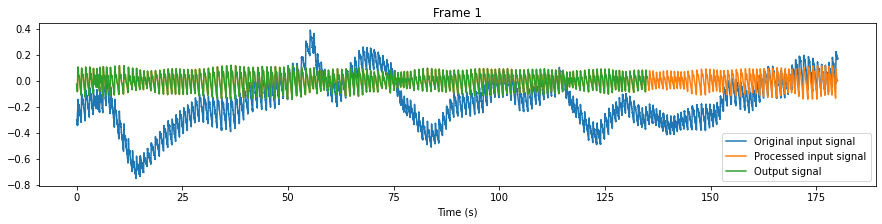

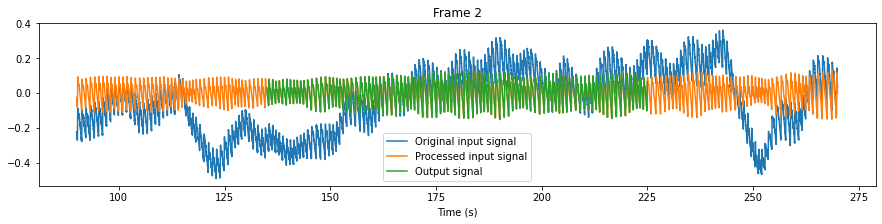

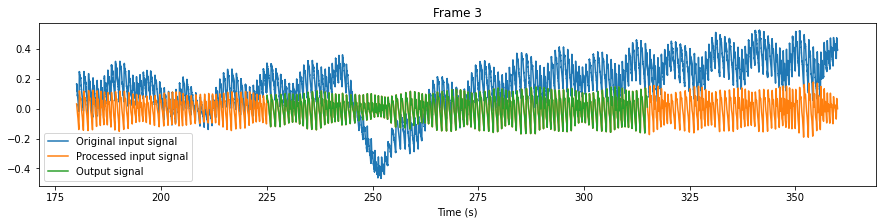

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


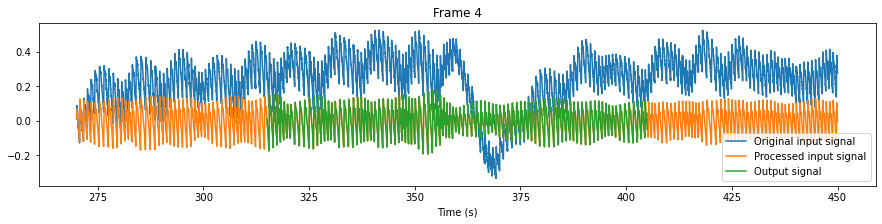

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


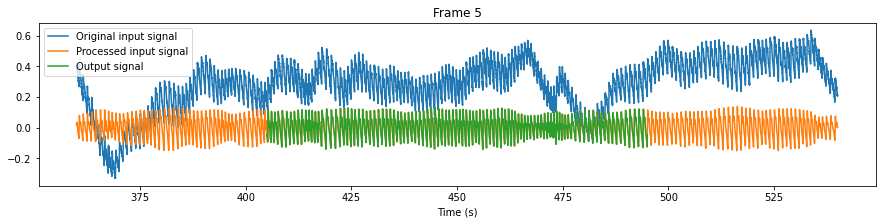

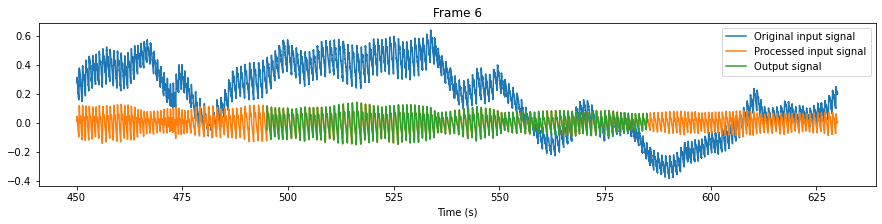

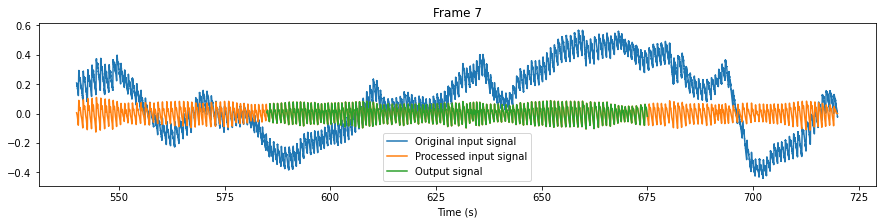

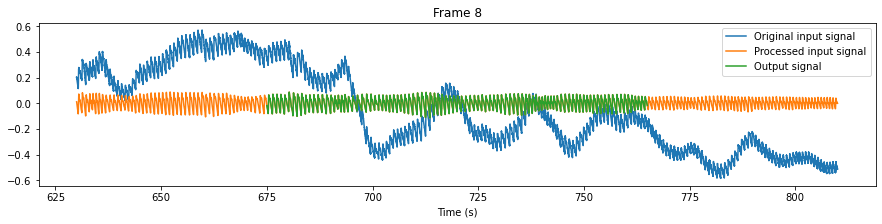

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


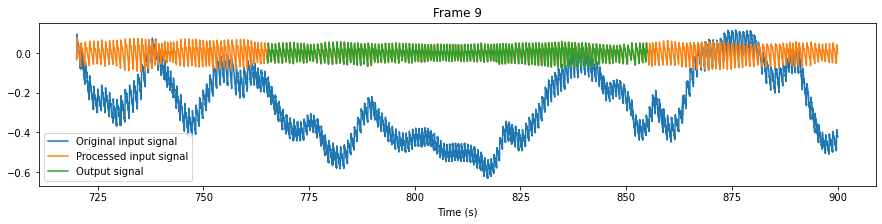

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


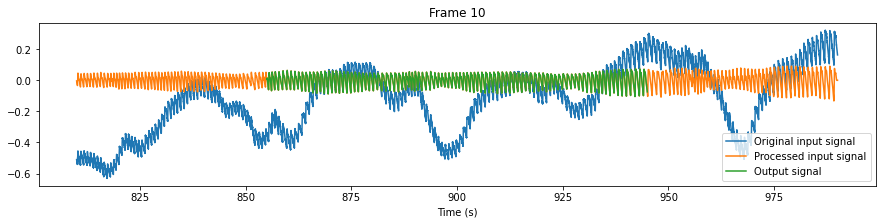

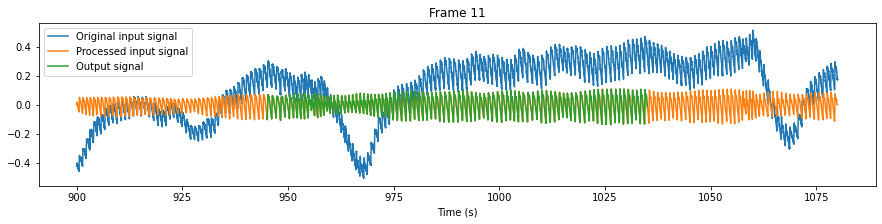

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


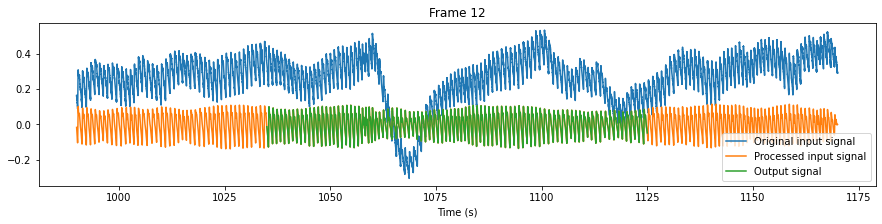

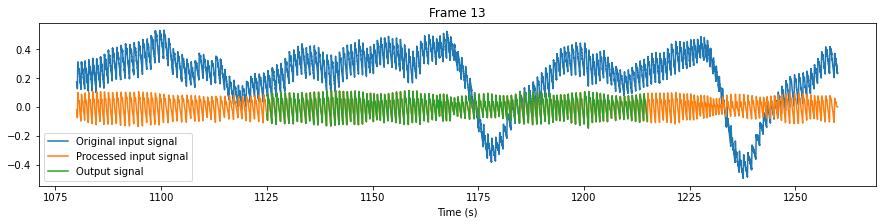

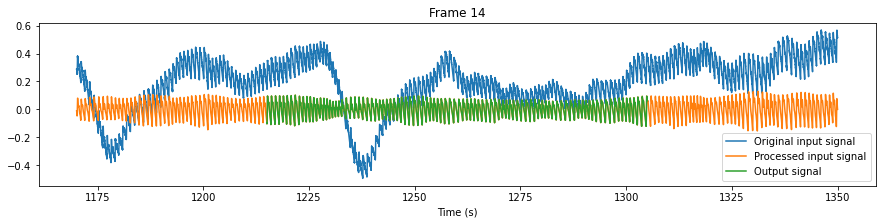

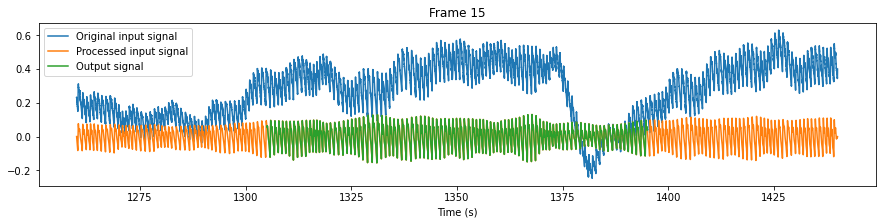

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


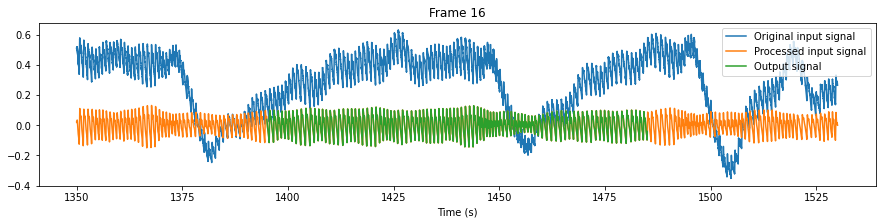

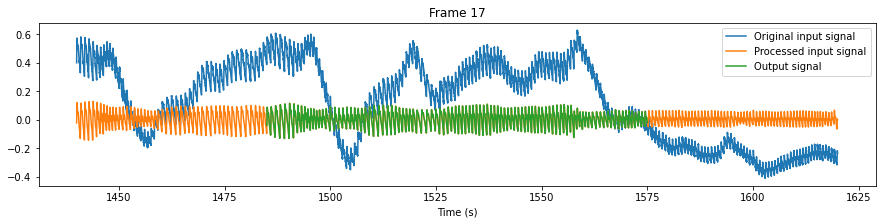

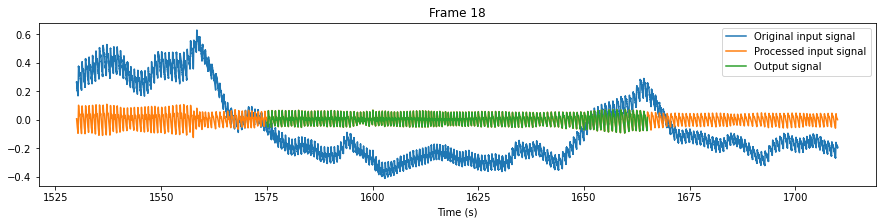

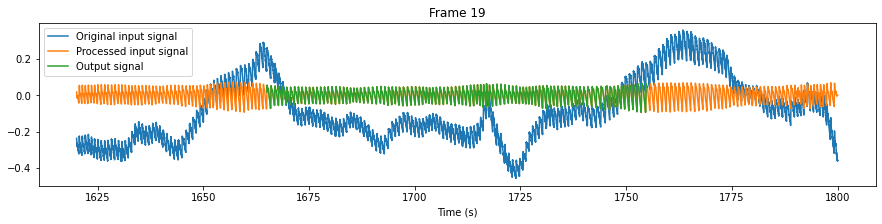

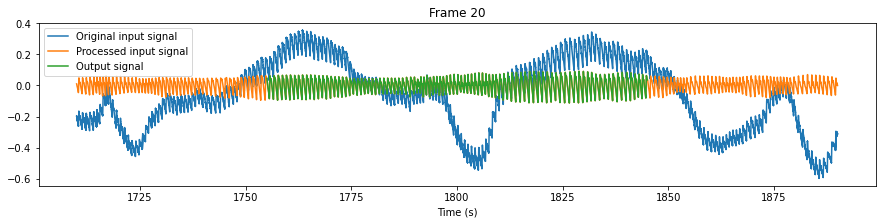

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


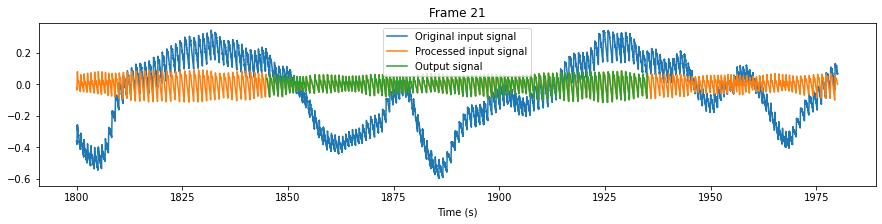

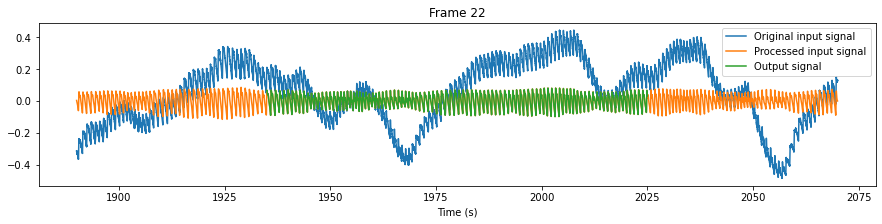

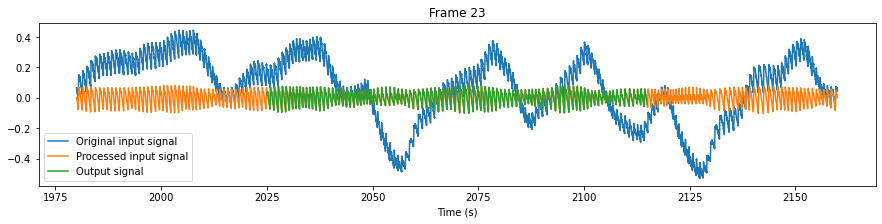

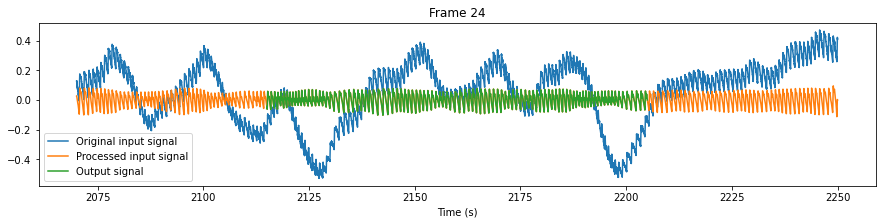

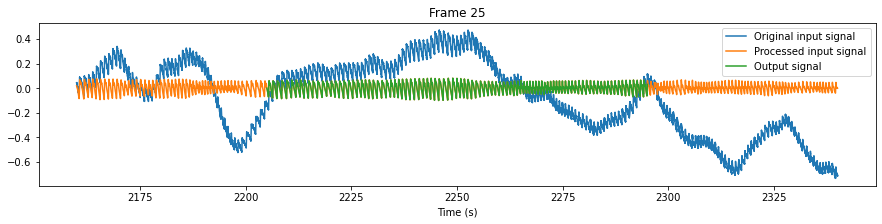

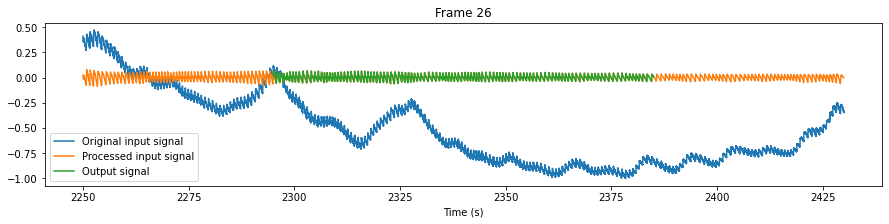

MemoryError: Unable to allocate 2.75 MiB for an array with shape (1440000, 2) and data type bool

<Figure size 1080x216 with 1 Axes>

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


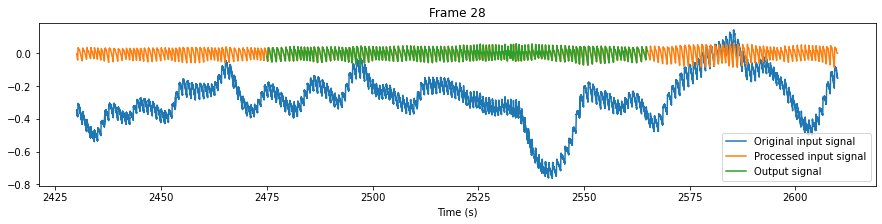

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


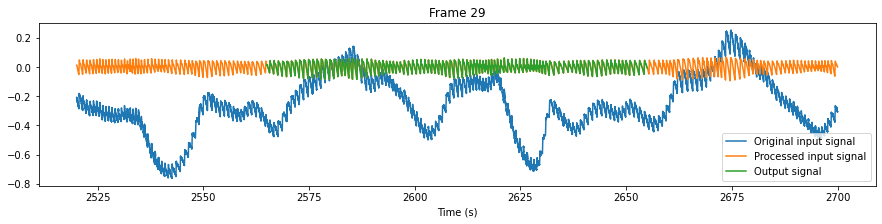

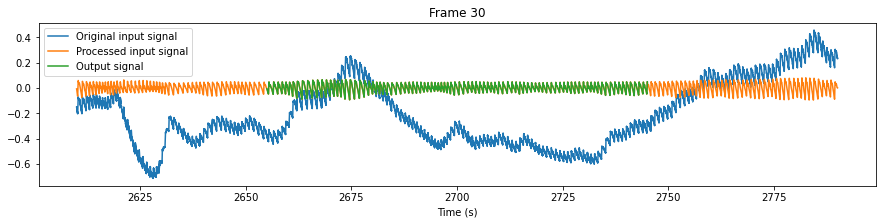

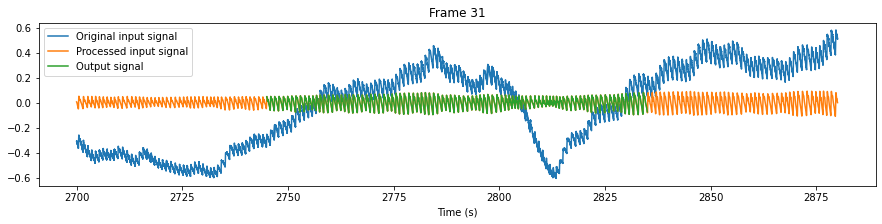

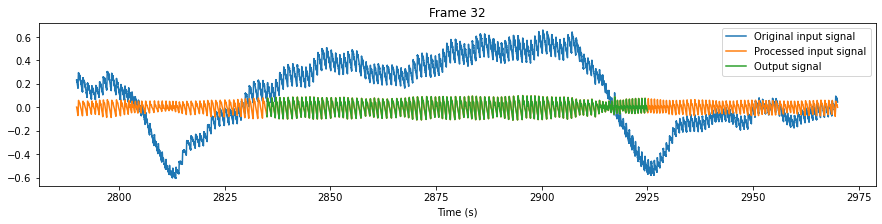

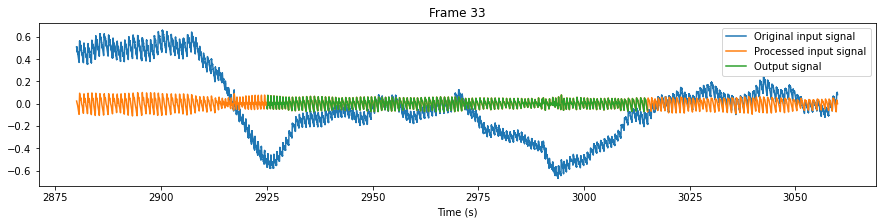

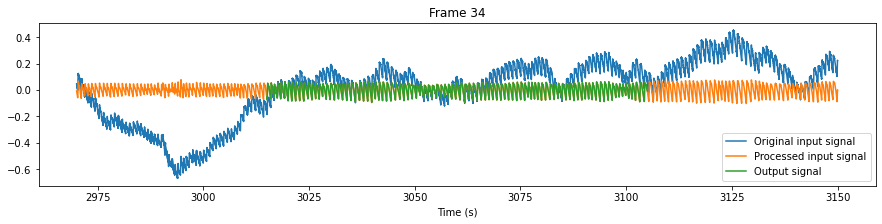

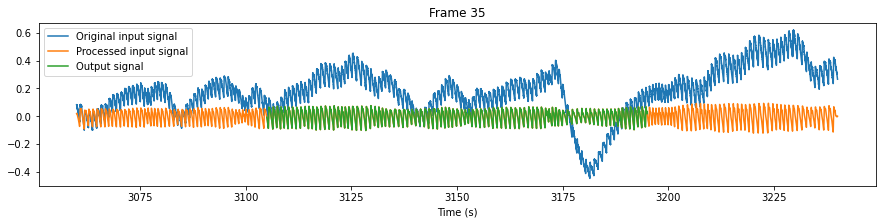

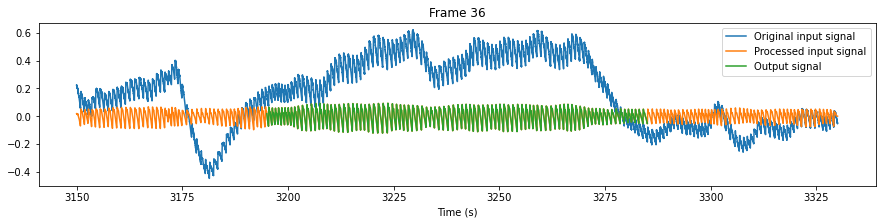

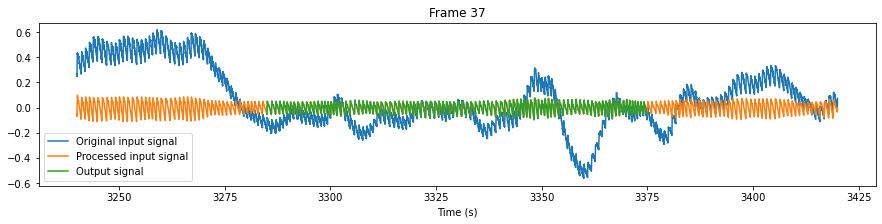

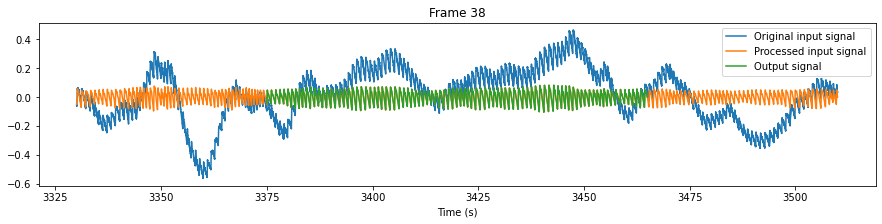

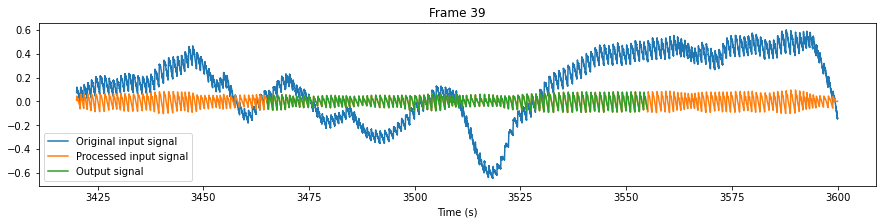

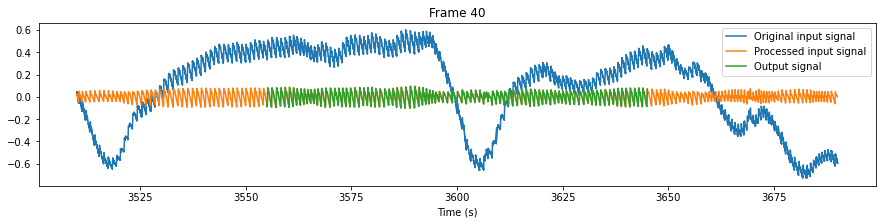

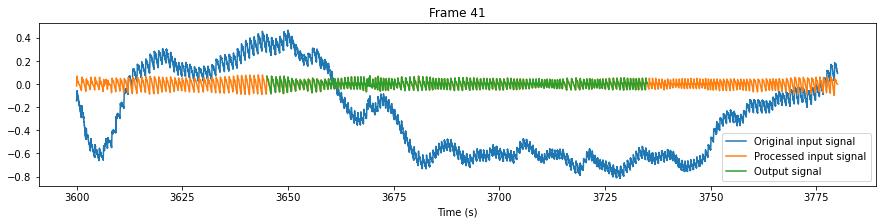

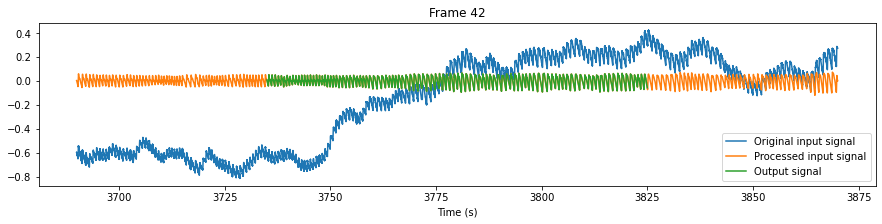

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


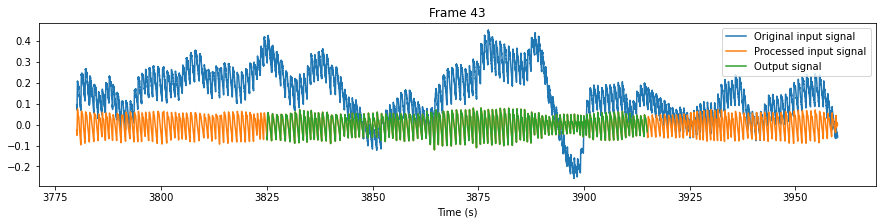

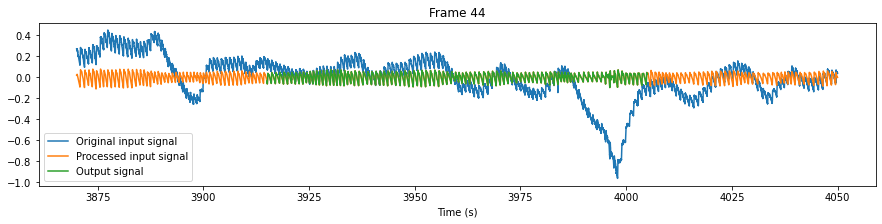

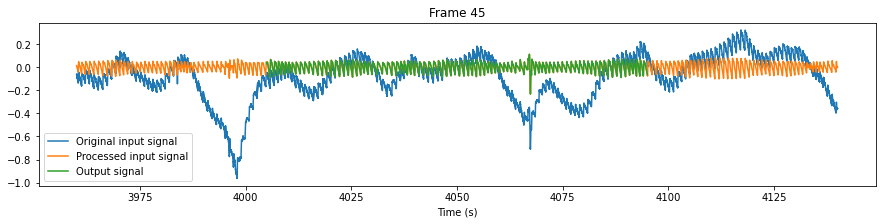

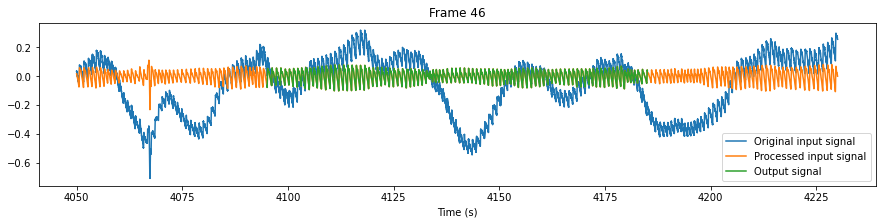

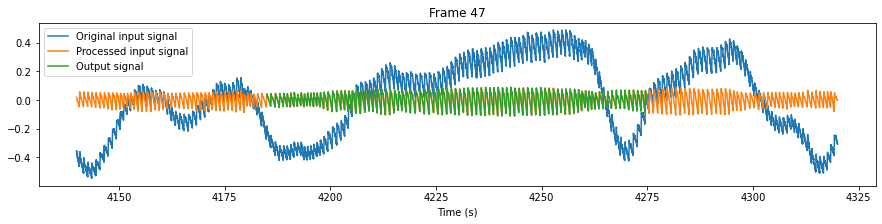

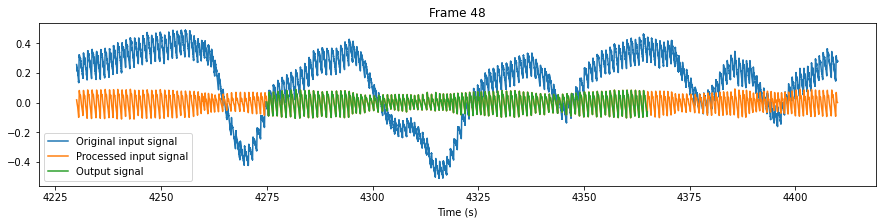

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


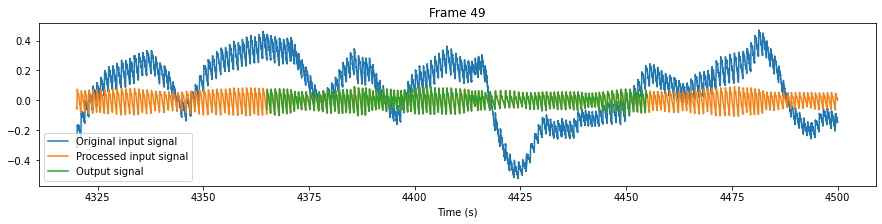

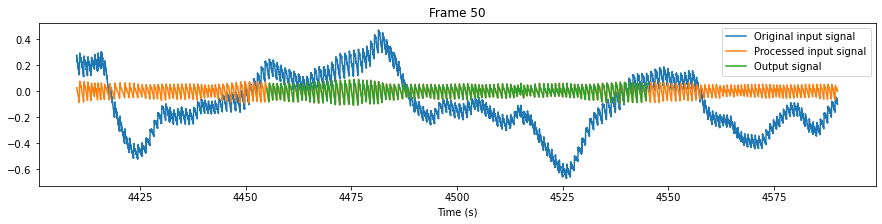

C:\Users\dbenesch\.conda\envs\stress-requirements\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


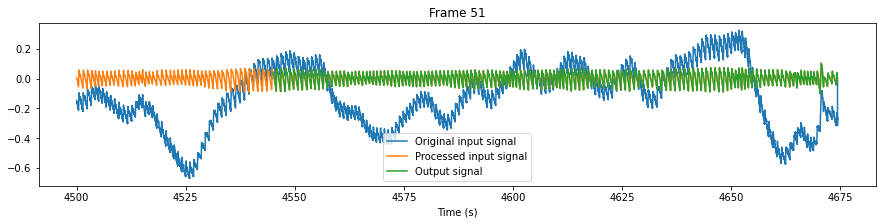

In [129]:
ppg_cleaned_info = clean_ppg(
    sig=sig_info["sig"],
    sig_time=sig_info["time"],
    wav_path=wav_path,
    sampling_rate=sig_info["sampling_rate"],
    frame_len=180,
    show=True
)

TypeError: can only concatenate list (not "Line2D") to list

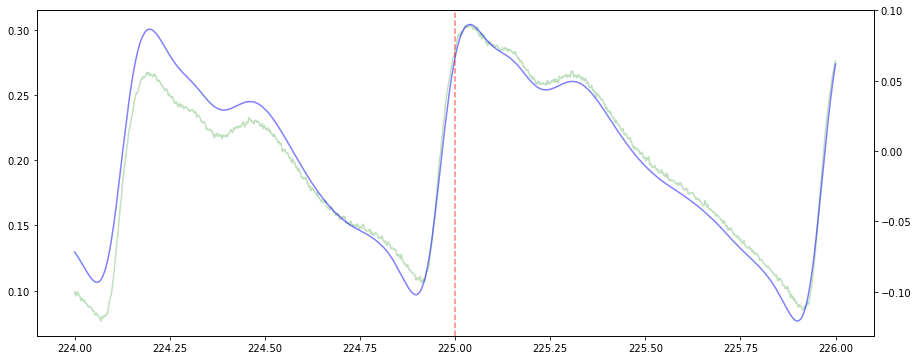

In [142]:
sub_label = "P06"

loader = P5_StressDataLoader(sub_id=sub_label)
sig_name = "ti_ppg"
st = 224
en = 226

ppg_cleaned_info = loader.get_sig(sig_name, file_path=wav_path, start_time=st, end_time=en)
ppg_orig_info = loader.get_sig(sig_name, file_path=file_path, start_time=st, end_time=en)
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
ppg_fs = ppg_cleaned_info["sampling_rate"]

ax2 = ax1.twinx()

lns1 = ax1.plot(
    ppg_orig_info["time"], ppg_orig_info["sig"],
    "g",
    alpha=0.25,
    label="Original input signal"
)
lns2 = ax2.plot(ppg_cleaned_info["time"], ppg_cleaned_info["sig"], "b", alpha=0.5, label="Output signal")
lns3 = plt.axvline(x=225, color='r', linestyle='--', alpha=0.5, label="Frame transition")
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Raw PPG", color="g")
ax2.set_ylabel("Clean PPG", color="b")
plt.title("Output signal with frames appended")

In [76]:

sig=sig_info["sig"]
sig_time=sig_info["time"]
sampling_rate=sig_info["sampling_rate"]
frame_len = 180
in_start_stop, out_start_stop = get_frame_start_stop(sig_time, frame_len=frame_len)
frame_n = 27
frame_sig = get_frame(sig, sig_time, in_start_stop, frame_n)
frame_sig_time = get_frame(sig_time, sig_time, in_start_stop, frame_n)
frame_sig_time_r = frame_sig_time
frame_sig_r = nk.signal_filter(
                frame_sig,
                sampling_rate=sampling_rate,
                lowcut=0.5,
                highcut=8.0,
            )

In [77]:
frame_sig_time_r

array([2340.      , 2340.000125, 2340.00025 , ..., 2519.999625,
       2519.99975 , 2519.999875])

(2460.0, 2470.0)

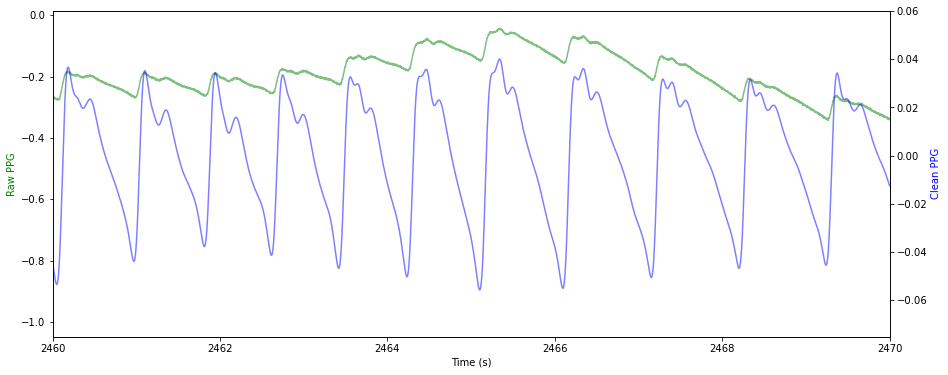

In [78]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
st = 2400
en = 2410
ppg_fs = clean_sig_info["sampling_rate"]

ax2 = ax1.twinx()

ax1.plot(
    frame_sig_time, frame_sig,
    "g",
    alpha=0.5,
)
ax2.plot(frame_sig_time_r, frame_sig_r, "b", alpha=0.5)

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Raw PPG", color="g")
ax2.set_ylabel("Clean PPG", color="b")

plt.xlim([2460, 2470])

In [69]:
sub_label = "P06"

loader = P5_StressDataLoader(sub_id=sub_label)
sig_name = "ti_ppg"
clean_sig_info = loader.get_sig(sig_name, file_path=wav_path)

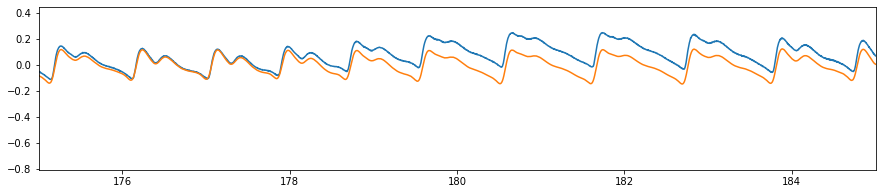

In [70]:
plt.figure(figsize=(15, 3))
# plt.plot(sig_info["time"], sig_info["sig"])
fs = clean_sig_info["sampling_rate"]
st = 0
en = 190
plt.plot(
    sig_info["time"][st * fs : en * fs], sig_info["sig"][st * fs : en * fs]
)

plt.plot(
    clean_sig_info["time"][st * fs : en * fs], clean_sig_info["sig"][st * fs : en * fs]
)
plt.xlim([175, 185])
plt.show()

Text(0, 0.5, 'Clean PPG')

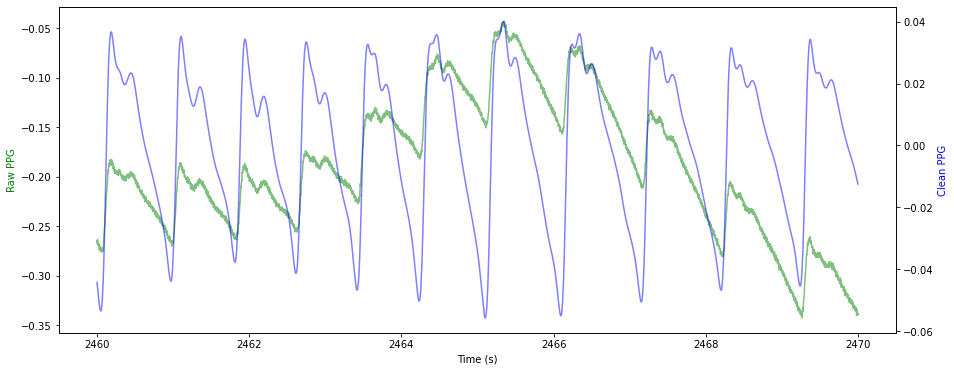

In [79]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
st = 2460
en = 2470
ppg_fs = clean_sig_info["sampling_rate"]

ax2 = ax1.twinx()

ax1.plot(
    sig_info["time"][st * ppg_fs : en * ppg_fs],
    sig_info["sig"][st * ppg_fs : en * ppg_fs],
    "g",
    alpha=0.5,
)
ax2.plot(clean_sig_info["time"][st * ppg_fs : en * ppg_fs],
    clean_sig_info["sig"][st * ppg_fs : en * ppg_fs], "b", alpha=0.5)

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Raw PPG", color="g")
ax2.set_ylabel("Clean PPG", color="b")


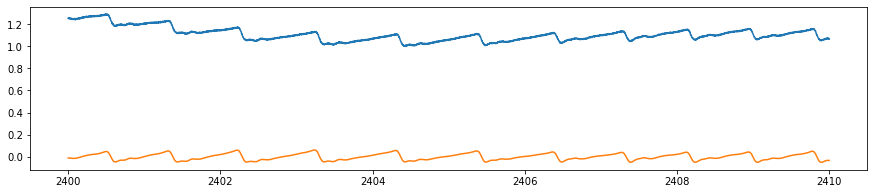

In [84]:
plt.figure(figsize=(15, 3))
# plt.plot(sig_info["time"], sig_info["sig"])
fs = clean_sig_info["sampling_rate"]
st = 2400
en = 2410
plt.plot(
    sig_info["time"][st * fs : en * fs], sig_info["sig"][st * fs : en * fs]/np.max(sig_info["sig"][st * fs : en * fs])
)

plt.plot(
    clean_sig_info["time"][st * fs : en * fs], clean_sig_info["sig"][st * fs : en * fs]/np.max()
)
plt.show()

In [61]:
ppg_cleaned = nk.ppg_clean(sig_info["sig"][st*fs:en*fs], sampling_rate=sig_info["sampling_rate"], method="nabian2018")

In [63]:
ppg_cleaned = nk.signal_filter(
    sig_info["sig"][st * fs : en * fs],
    sampling_rate=sig_info["sampling_rate"],
    lowcut=0.5,
    highcut=10,
)

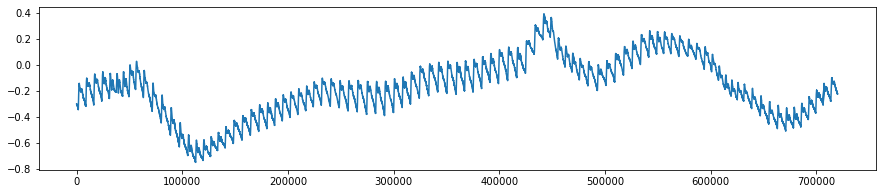

In [64]:
plt.figure(figsize=(15,3))
plt.plot(nk.as_vector(sig_info["sig"][st*fs:en*fs]))
plt.show()

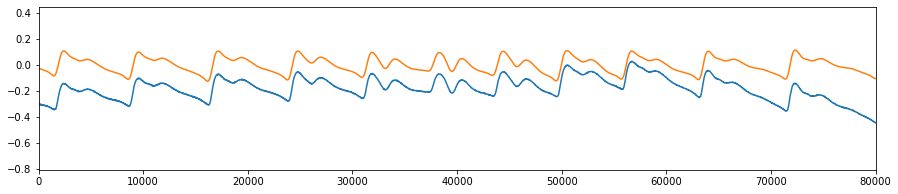

In [66]:
plt.figure(figsize=(15,3))
plt.plot(sig_info["sig"][st*fs:en*fs])
plt.plot(ppg_cleaned)
plt.xlim([0,fs*10])
plt.show()

In [41]:
ppg_signal = sig_info["sig"][st*fs:en*fs]
sampling_rate = sig_info["sampling_rate"]

In [81]:
filtered = nk.signal_filter(
        ppg_signal, sampling_rate=sampling_rate, lowcut=0.5, highcut=8, order=3, method="butter_ba"
    )

NameError: name 'ppg_signal' is not defined

NameError: name 'ppg_signal' is not defined

In [43]:
filtered

array([nan, nan, nan, ..., nan, nan, nan])

In [54]:
signal=ppg_signal

In [56]:
np.unique(np.isfinite(signal))

array([ True])

In [47]:
def _signal_filter_sanitize(lowcut=None, highcut=None, sampling_rate=1000, normalize=False):

    # Sanity checks
    if isinstance(highcut, int):
        if sampling_rate <= 2 * highcut:
            warn(
                "The sampling rate is too low. Sampling rate"
                " must exceed the Nyquist rate to avoid aliasing problem."
                f" In this analysis, the sampling rate has to be higher than {2 * highcut} Hz",
                category=NeuroKitWarning,
            )

    # Replace 0 by none
    if lowcut is not None and lowcut == 0:
        lowcut = None
    if highcut is not None and highcut == 0:
        highcut = None

    # Format
    if lowcut is not None and highcut is not None:
        if lowcut > highcut:
            filter_type = "bandstop"
        else:
            filter_type = "bandpass"
        freqs = [lowcut, highcut]
    elif lowcut is not None:
        freqs = [lowcut]
        filter_type = "highpass"
    elif highcut is not None:
        freqs = [highcut]
        filter_type = "lowpass"

    # Normalize frequency to Nyquist Frequency (Fs/2).
    # However, no need to normalize if `fs` argument is provided to the scipy filter
    if normalize is True:
        freqs = np.array(freqs) / (sampling_rate / 2)

    return freqs, filter_type

In [70]:
import scipy
lowcut=0.5
highcut=8
order=3
method="butter_ba"
freqs, filter_type = _signal_filter_sanitize(
        lowcut=lowcut, highcut=highcut, sampling_rate=sampling_rate
)

b, a = scipy.signal.butter(order, freqs, btype=filter_type, output="ba", fs=sampling_rate)
try:
    filtered = scipy.signal.filtfilt(b, a, signal, method="gust")
except ValueError:
    filtered = scipy.signal.filtfilt(b, a, signal, method="pad")

In [71]:
sampling_rate

8000

In [72]:
freqs

[0.5, 8]

In [73]:
filter_type

'bandpass'

In [74]:
filtered = scipy.signal.filtfilt(b, a, signal, method="pad")

In [75]:
filtered

array([nan, nan, nan, ..., nan, nan, nan])

In [76]:
filtered = scipy.signal.filtfilt(b, a, signal, method="gust")

ValueError: array must not contain infs or NaNs